#  **Master Thesis**

---
Topic

---



## **Getting started**

At first, we are performing below activites:

 1. --
 2. --
 3. --


In [2]:
'''%pip install plotly
%pip install statsmodels  
%pip install keras
%pip install tensorflow
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install prophet
%pip install xgboost
%pip install findspark   
%pip install pyodbc

%pip install pandas
%pip install pyspark 

'''

'''
print('PySpark version:', pyspark.__version__)
print('Spark version:', spark.version)

%pip install "pyspark==3.5.0" --force-reinstall
%pip install --upgrade nbformat
'''


'\nprint(\'PySpark version:\', pyspark.__version__)\nprint(\'Spark version:\', spark.version)\n\n%pip install "pyspark==3.5.0" --force-reinstall\n%pip install --upgrade nbformat\n'

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from sklearn.cluster import BisectingKMeans, KMeans
import plotly.graph_objects as go
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from prophet import Prophet
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.dates as mdates
from prophet.plot import add_changepoints_to_plot


import pyspark
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import warnings




# prevents numpy and pandas scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.4f}'.format})
pd.options.display.float_format = '{:.4f}'.format
sns.set_style('whitegrid')
# ignoring warnings, suppressing/preventing/hushing up all warnings
warnings.filterwarnings(action='ignore')

In [ ]:
'''
    Pyspark handles the complexities of multiprocessing, such as :
                            distributing the data, 
                            distributing code and 
                            collecting output from the workers on a cluster/group/set of machines.
    SparkContext:                          
                    SparkContext is the primary point of entry for Spark capabilities. 
                    A SparkContext represents a Spark cluster's connection that is useful in building RDDs, 
                    accumulators, and broadcast variables on the cluster.        
                                    
                    To create a SparkContext you first need to build a SparkConf object that contains 
                    information about your application.                     
                        
    SQLContext:                         
                    SQLContext enables applications to run SQL queries programmatically while running SQL functions and 
                    returns the result as a DataFrame.                         
                           
'''
'''  PySpark SQL Server - via JDBC
     Creating a SparkSession is a basic step to work with PySpark hence, first, let's create a SparkSession
'''
'''
     Enable Arrow-based spark configuration
     Pandas DataFrames are executed on a driver/single machine. While Spark DataFrames, are distributed across nodes of the Spark cluster.
     The easiest way to convert Pandas DataFrames to PySpark is through Apache Arrow.

'''


spark = SparkSession.builder.appName("Master_Thesis_Part_4").config("spark.jars", "C:\Spark\spark3\jars\sqljdbc_12.6.1.0_enu.jar").getOrCreate()

url = 'jdbc:sqlserver://DESKTOP-3REJ4PS\\SQLFULL:1433;databaseName=TransRepository;user=dathscom;password=987654321;encrypt=true;trustServerCertificate=true'

#spark.conf.set('spark.sql.execution.arrow.enabled', 'true')

In [ ]:
# %pip list

print('PySpark version:', pyspark.__version__)
print('Spark version:', spark.version)

PySpark version: 3.3.1
Spark version: 3.3.1


Main transactional dataset which will be examined
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url', url).option('dbtable','dbo.t_fund_transactions').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions t where t.topcategory is not null '''

working_df = spark.sql(sql_query)

working_df.show(10)

+-------+-------+----------+----------+-----------+--------+-------------+
| Regnum|   Card|      Date|    Amount|SubCategory|Category|  TopCategory|
+-------+-------+----------+----------+-----------+--------+-------------+
|3463115|4210714|2019-04-09|   75.2000|       5814|    food|     Survival|
|2851896|4151026|2019-04-09|  121.1900|       5411|    food|     Survival|
|2551702|3552313|2019-04-09|  223.0000|       5814|    food|     Survival|
| 449374|4078059|2019-04-09|  100.0000|       5411|    food|     Survival|
|2823984|4610098|2019-04-09|  500.0000|       5814|    food|     Survival|
|3058708|4167128|2019-04-09|  852.2100|       5411|    food|     Survival|
| 829659|4205377|2019-04-09| 2500.1200|       5541|  travel|Socialization|
| 582038|4283625|2019-04-09| 1000.1100|       5541|  travel|Socialization|
|2886066|4026685|2019-04-09|10000.0000|       6011|   money|        Money|
|2536601|3459575|2019-04-09|  294.0000|       5814|    food|     Survival|
+-------+-------+--------

Inspecting dataframe structure and exploratory data analysis in pyspark
---

In [ ]:
''' 
     schema, columns & datatypes of the dataset
'''
print('Data overview')
working_df.printSchema()
print('Columns overview')
pd.DataFrame(working_df.dtypes, columns = ['Column name','Data type'])

Data overview
root
 |-- Regnum: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Amount: decimal(19,4) (nullable = true)
 |-- SubCategory: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- TopCategory: string (nullable = true)

Columns overview


Column name      Data type
0       Regnum            int
1         Card            int
2         Date           date
3       Amount  decimal(19,4)
4  SubCategory         string
5     Category         string
6  TopCategory         string

In [ ]:
''' describe() is used to view some basic statistical details like percentile, mean, std, etc. of a DataFrame, i.e.
    getting some statictical inferences, summary statistics for decimal(19,4) variables
'''

decimal_features = [t[0] for t in working_df.dtypes if t[1] == 'decimal(19,4)']
working_df.select(decimal_features).describe().show()

+-------+-----------------+
|summary|           Amount|
+-------+-----------------+
|  count|         19026862|
|   mean|    1735.54141778|
| stddev|9898.287190574943|
|    min|           0.0100|
|    max|    18200000.0000|
+-------+-----------------+



In [ ]:
''' getting numbers of nans/missing values from each fields

    checking null values in Pyspark

        isnan() is a function of the pysparq.sql.function package, we have to set which column we want to use as an argument of the function
        isNull() belongs to pyspark.sql.Column package, to check the null status of a column

    to check null in Pyspark, we have to use isNull() function

'''

working_df.select([count(when(col(c).isNull(), c)).alias(c) for c in working_df.columns]).show()   # count(when(isnan(c) | col(c).isNull(), c))   

+------+----+----+------+-----------+--------+-----------+
|Regnum|Card|Date|Amount|SubCategory|Category|TopCategory|
+------+----+----+------+-----------+--------+-----------+
|     0|   0|   0|     0|          0|       0|          0|
+------+----+----+------+-----------+--------+-----------+



Aggregating amount by categorical variables (MCCs) as category and topcategory between 2018 and 2022 based on month
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_monthly_by_category_sum_2018_2022').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_monthly_by_category_sum_2018_2022")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_monthly_by_category_sum_2018_2022 t order by t.monthly asc '''


working_df = spark.sql(sql_query)
working_df.show(10)


+----------+--------------+--------+----------------+
|   Monthly|        Amount|Category|     TopCategory|
+----------+--------------+--------+----------------+
|2018-01-31| 18704241.8900|  travel|   Socialization|
|2018-01-31| 48807402.7800|    food|        Survival|
|2018-01-31|  3289996.7300|  beauty|Self-Realization|
|2018-01-31|  8465998.7400|  health|        Survival|
|2018-01-31|248388085.6200|   money|           Money|
|2018-01-31|  7589020.7500| nonfood|   Socialization|
|2018-01-31| 13250478.0800|  outfit|        Survival|
|2018-01-31|  1769601.9300|    misc|   Socialization|
|2018-01-31|  3312628.4600|    kids|Self-Realization|
|2018-01-31|   680010.6500|  remote|   Socialization|
+----------+--------------+--------+----------------+
only showing top 10 rows



Transformation and visualization
---

### Transforming numeric variables

Instantly, we have to take into account the scalability of the machine learning models. Thus, to improve performance of machine learning models transformations of the values are often applied. Typically, transformations are used to make the relationships between variables more linear. In other cases, transformations are performed to make distributions closer to normal, or at least more symmetric. These transformations can include taking logarithms, exponential transformations and power transformations.

#####  Feature scaling : numeric/decimal variables

Before that the dataset will be split, the numeric feature column must be re-scaled. Rescaling of numeric features is extremely important. The numeric range of a feature should not determine how much that feature determines the training of the machine learning model. 

For example, consider a data set with two features, age in years, typically measured in a few tens, and income, typically measured in tens or hundreds of thousands. There is no reason to believe that income is more important than age in some model, simply because its range of values is greater. To prevent this problem numeric features are scaled to the same range. 

There are many possible scaling method which are: **Standard Scaler**, **MinMax Scaler**, **Robust Scaler** and **Normalize**

### Visualization

Before using visual libraries such as matplotlib or seaborn, we need to convert SparkDataframe to PandasDataFrame.

Spark to Pandas : df_pd = df.toPandas()

Pandas to Spark : df_sp = spark_session.createDataFrame(df_pd)


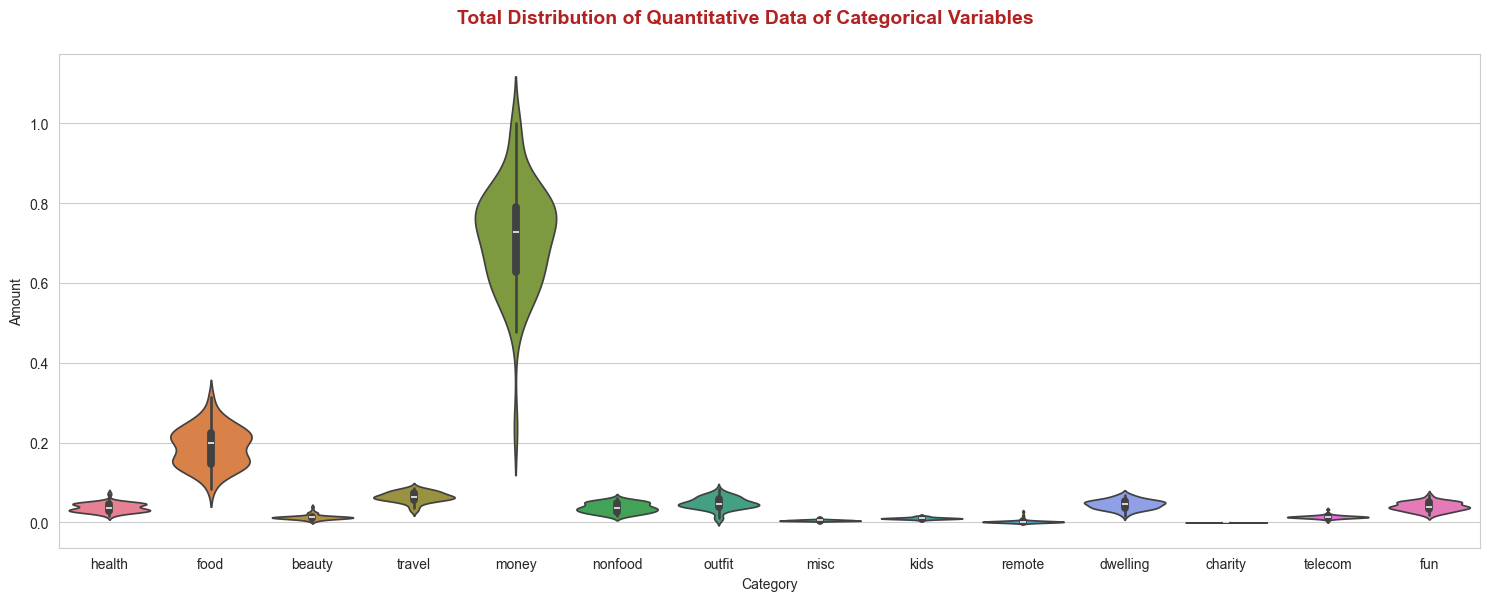

In [ ]:
'''
   violinplot draws a combination of boxplot and kernel density estimate. It plays a similar role as a box and whisker plot. 
   It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. 
   It features a kernel density estimation of the underlying distribution. This can be an effective and attractive way to show multiple distributions 
   of data at once, but we keep in mind that the estimation procedure is influenced by the sample size.
 
'''

temp_df = working_df.toPandas()

scaler = MinMaxScaler(feature_range=(0,1))
temp_df[['Amount']] = scaler.fit_transform(temp_df[['Amount']])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6)) 
sns.violinplot(data = temp_df, x = 'Category', y = 'Amount', hue='Category', ax=ax)

fig.suptitle('Total Distribution of Quantitative Data of Categorical Variables', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Total_Distribution_of_Quantitative_Data_of_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

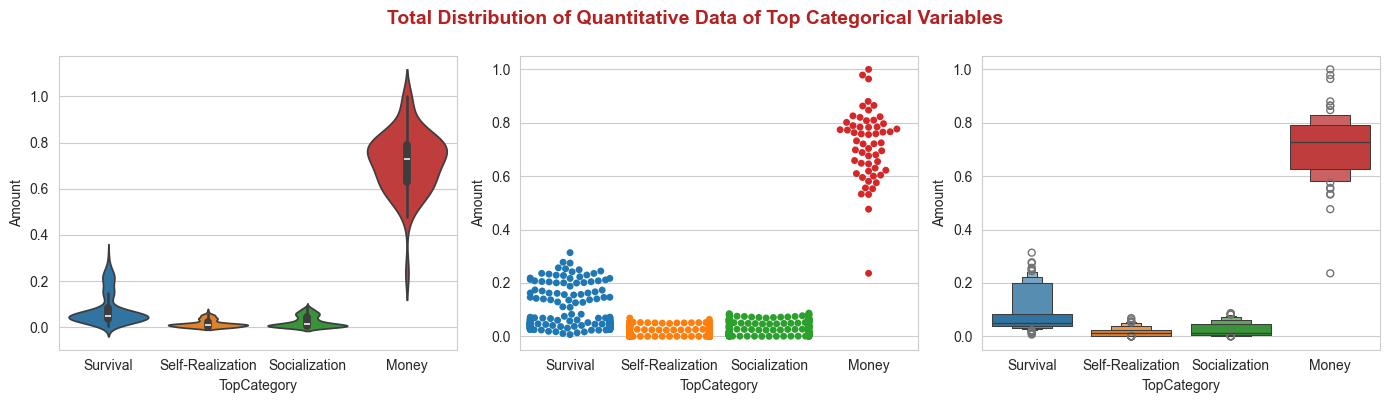

In [ ]:
'''
   violinplot draws a combination of boxplot and kernel density estimate. It plays a similar role as a box and whisker plot. 
   It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. 
   It features a kernel density estimation of the underlying distribution. This can be an effective and attractive way to show multiple distributions 
   of data at once, but we keep in mind that the estimation procedure is influenced by the sample size.
 
'''

temp_df = working_df.toPandas()

scaler = MinMaxScaler(feature_range=(0,1))
temp_df[['Amount']] = scaler.fit_transform(temp_df[['Amount']])


fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 4))
ax = ax.flat
for i in range(0, 3, 1):
    if i == 0:
        sns.violinplot(data = temp_df,x = 'TopCategory', y = 'Amount', hue='TopCategory', ax = ax[i])
    elif i == 1:
        sns.swarmplot(data = temp_df, x = 'TopCategory', y = 'Amount', hue='TopCategory', ax = ax[i]) 
    else:
        sns.boxenplot(data = temp_df, x = 'TopCategory', y = 'Amount', hue='TopCategory', ax = ax[i]) 

fig.suptitle('Total Distribution of Quantitative Data of Top Categorical Variables', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Total_Distribution_of_Quantitative_Data_of_Top_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Monthly aggregated amount by top categories between 2018 and 2022
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_monthly_by_topcategory_sum_mean_2018_2022').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_monthly_by_topcategory_sum_mean_2018_2022")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_monthly_by_topcategory_sum_mean_2018_2022 t order by t.monthly asc '''

working_df = spark.sql(sql_query)

working_df.show(10)

+----------+--------------+-----------------+--------------------+--------------+-------------+------------------+---------------------+----------+
|   Monthly|  Survival_sum|Socialization_sum|Self-Realization_sum|     Money_sum|Survival_mean|Socialization_mean|Self-Realization_mean|Money_mean|
+----------+--------------+-----------------+--------------------+--------------+-------------+------------------+---------------------+----------+
|2018-01-31| 81263374.7900|    43428799.9700|       17522785.6600|248388085.6200|    1647.7427|         2861.8649|            2147.6633| 9027.0419|
|2018-02-28| 82059011.8900|    32563375.9900|       18495554.2900|294121022.7300|    1646.8453|         2269.3829|            2280.5862| 9239.7908|
|2018-03-31|104630609.5800|    42772349.4100|       24200630.7300|340600444.5400|    1676.6382|         2443.4361|            2295.4216| 9157.6491|
|2018-04-30|100702947.8500|    42318052.4500|       19873194.3000|342670285.6600|    1701.4081|         2408.677

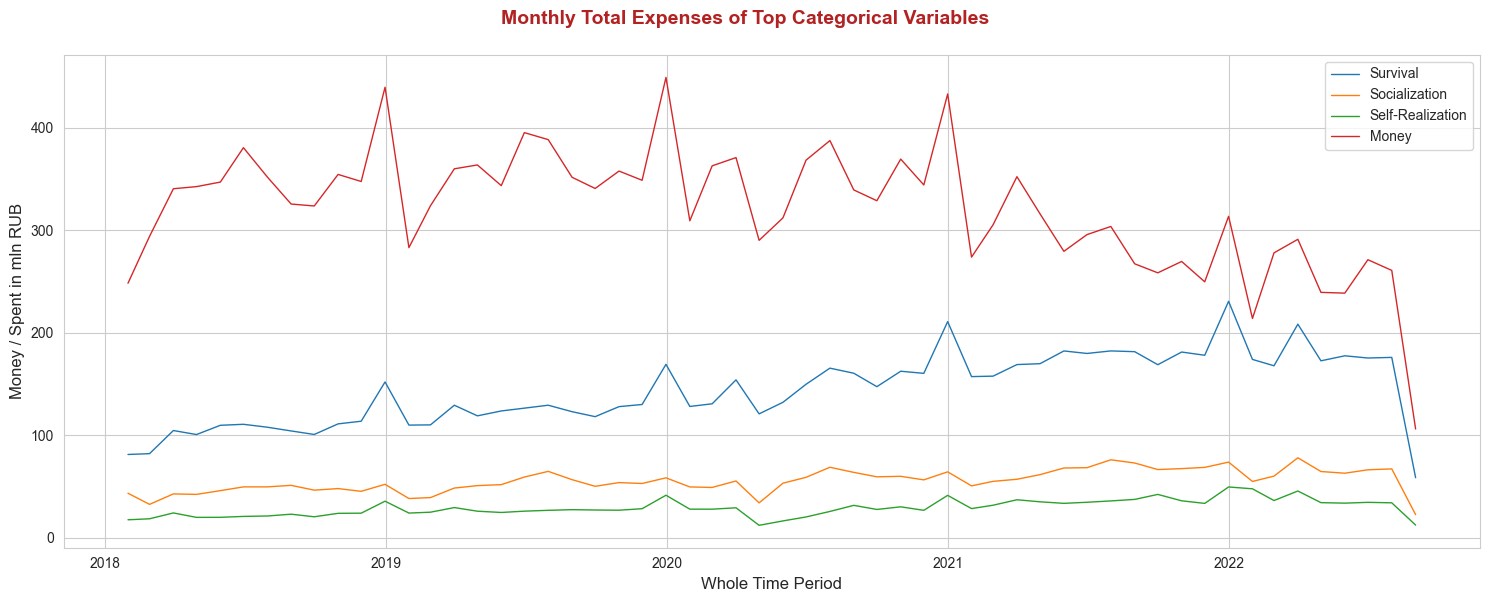

In [ ]:
# plotting the graph

temp_df = working_df.toPandas()

temp_df.Monthly = pd.to_datetime(temp_df.Monthly)  # it takes care of chronology(across visualization packages) and assign appropriate x-ticks and intervals

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(data=temp_df, y=temp_df['Survival_sum'].astype(float)/1e6, x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=temp_df, y=temp_df['Socialization_sum'].astype(float)/1e6, x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=temp_df, y=temp_df['Self-Realization_sum'].astype(float)/1e6, x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=temp_df, y=temp_df['Money_sum'].astype(float)/1e6, x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Money') # , marker = "o", markersize = 2
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Whole Time Period', fontsize=12)
ax.set_ylabel('Money / Spent in mln RUB', fontsize=12)

fig.suptitle('Monthly Total Expenses of Top Categorical Variables', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Monthly_Total_ExpensesofTop_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

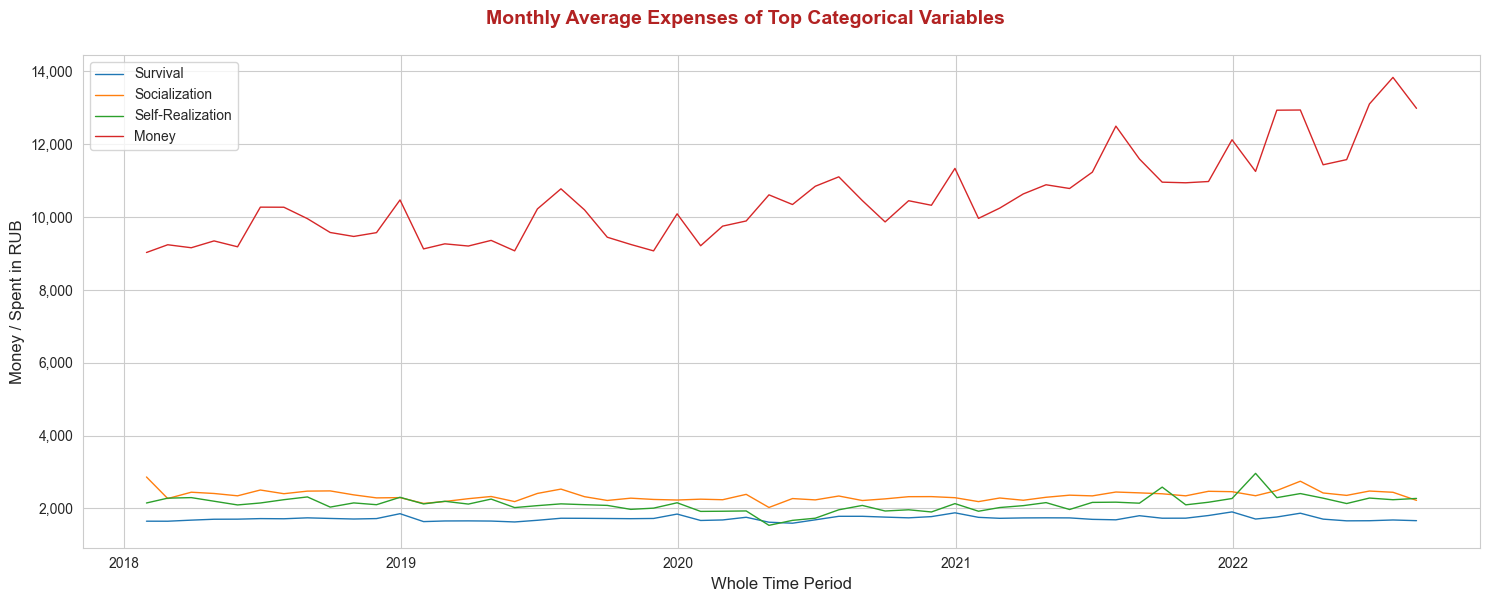

In [ ]:
# plotting the graph

temp_df = working_df.toPandas()

temp_df.Monthly = pd.to_datetime(temp_df.Monthly)  # it takes care of chronology(across visualization packages) and assign appropriate x-ticks and intervals

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(data=temp_df, y=temp_df['Survival_mean'], x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=temp_df, y=temp_df['Socialization_mean'], x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=temp_df, y=temp_df['Self-Realization_mean'], x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=temp_df, y=temp_df['Money_mean'], x=temp_df['Monthly'], palette="nipy_spectral", linewidth=1, ax=ax, label='Money')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Whole Time Period', fontsize=12)
ax.set_ylabel('Money / Spent in RUB', fontsize=12)

fig.suptitle('Monthly Average Expenses of Top Categorical Variables', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Monthly_Average_ExpensesofTop_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Monthly Distribution of All Categorical Variables
---

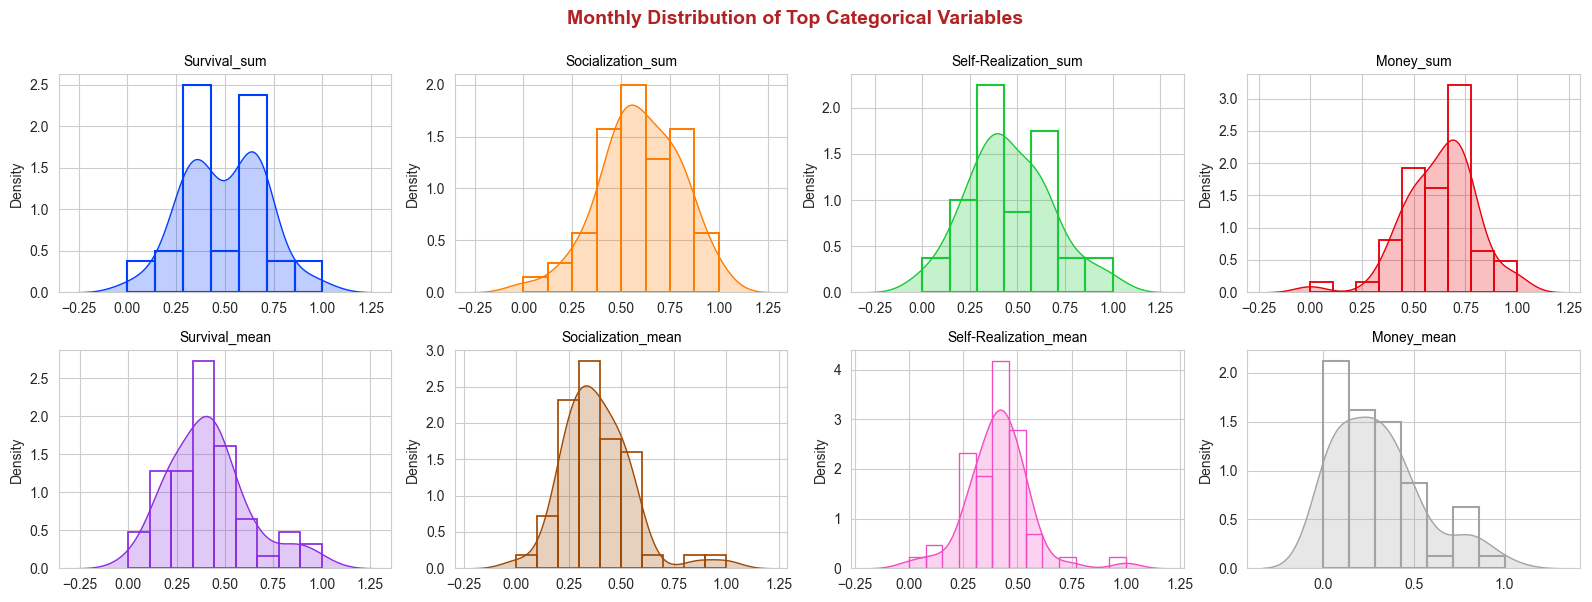

In [ ]:
decimal_features = [t[0] for t in working_df.dtypes if t[1] == 'decimal(19,4)']
temp_df = working_df.select(decimal_features).toPandas()

scaler = MinMaxScaler()
temp_df[['Survival_sum']] = scaler.fit_transform(temp_df[['Survival_sum']])
temp_df[['Socialization_sum']] = scaler.fit_transform(temp_df[['Socialization_sum']])
temp_df[['Self-Realization_sum']] = scaler.fit_transform(temp_df[['Self-Realization_sum']])
temp_df[['Money_sum']] = scaler.fit_transform(temp_df[['Money_sum']])

temp_df[['Survival_mean']] = scaler.fit_transform(temp_df[['Survival_mean']])
temp_df[['Socialization_mean']] = scaler.fit_transform(temp_df[['Socialization_mean']])
temp_df[['Self-Realization_mean']] = scaler.fit_transform(temp_df[['Self-Realization_mean']])
temp_df[['Money_mean']] = scaler.fit_transform(temp_df[['Money_mean']])


colors = sns.color_palette(palette = 'bright', n_colors = len(temp_df.columns),)

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 6))
ax = ax.flat
for i, column_name in enumerate(temp_df.columns):
    sns.kdeplot(temp_df, x = column_name, fill = True, color = colors[i], ax = ax[i])
    sns.histplot(temp_df, x = column_name, stat = 'density', fill = False, color = colors[i], ax = ax[i])
    ax[i].set_title(column_name, fontsize = 10, color = 'black') 
    ax[i].set_xlabel('')
    
fig.suptitle("Monthly Distribution of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Distribution_of_Top_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()


---

Weekly aggregated (summed) amount by client and top categories between: 
---
 + 2019-02-01 and 2019-05-31
 + 2020-02-01 and 2020-05-31
 + 2021-02-01 and 2021-05-31


In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df_2019 = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_client_2019').load()
working_df_2020 = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_client_2020').load()
working_df_2021 = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_client_2021').load()
working_df_2022 = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_client_2022').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df_2019.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_client_2019")
working_df_2020.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_client_2020")
working_df_2021.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_client_2021")
working_df_2022.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_client_2022")

''' writing the dml '''
sql_query_2019 = ''' select * from t_fund_transactions_weekly_sum_by_client_2019 t order by t.Date asc '''
sql_query_2020 = ''' select * from t_fund_transactions_weekly_sum_by_client_2020 t order by t.Date asc '''
sql_query_2021 = ''' select * from t_fund_transactions_weekly_sum_by_client_2021 t order by t.Date asc '''
sql_query_2022 = ''' select * from t_fund_transactions_weekly_sum_by_client_2022 t order by t.Date asc '''


working_df_2019 = spark.sql(sql_query_2019)
working_df_2020 = spark.sql(sql_query_2020)
working_df_2021 = spark.sql(sql_query_2021)
working_df_2022 = spark.sql(sql_query_2022)


working_df_2019.show(10)

+----------+-------+----------+-------------+----------------+----------+
|      Date| Client|  Survival|Socialization|Self-Realization|     Money|
+----------+-------+----------+-------------+----------------+----------+
|2019-02-03| 493359|    0.0000|       0.0000|        734.0000| 1000.0000|
|2019-02-03|2178651| 1631.7600|    1363.0800|          0.0000|    0.0000|
|2019-02-03|3072569|24596.0000|       0.0000|       1749.0000|    0.0000|
|2019-02-03|2074987|    0.0000|       0.0000|          0.0000|20000.0000|
|2019-02-03|2520611| 4209.0000|       0.0000|          0.0000|    0.0000|
|2019-02-03|3180867| 1393.4800|       0.0000|          0.0000| 4900.0000|
|2019-02-03|2922190| 1598.0700|       0.0000|          0.0000|    0.0000|
|2019-02-03|2175900|    0.0000|   36930.8000|          0.0000|    0.0000|
|2019-02-03|3420812| 1432.6000|       0.0000|          0.0000|    0.0000|
|2019-02-03|2250281|  987.7800|       0.0000|          0.0000| 2000.0000|
+----------+-------+----------+-------

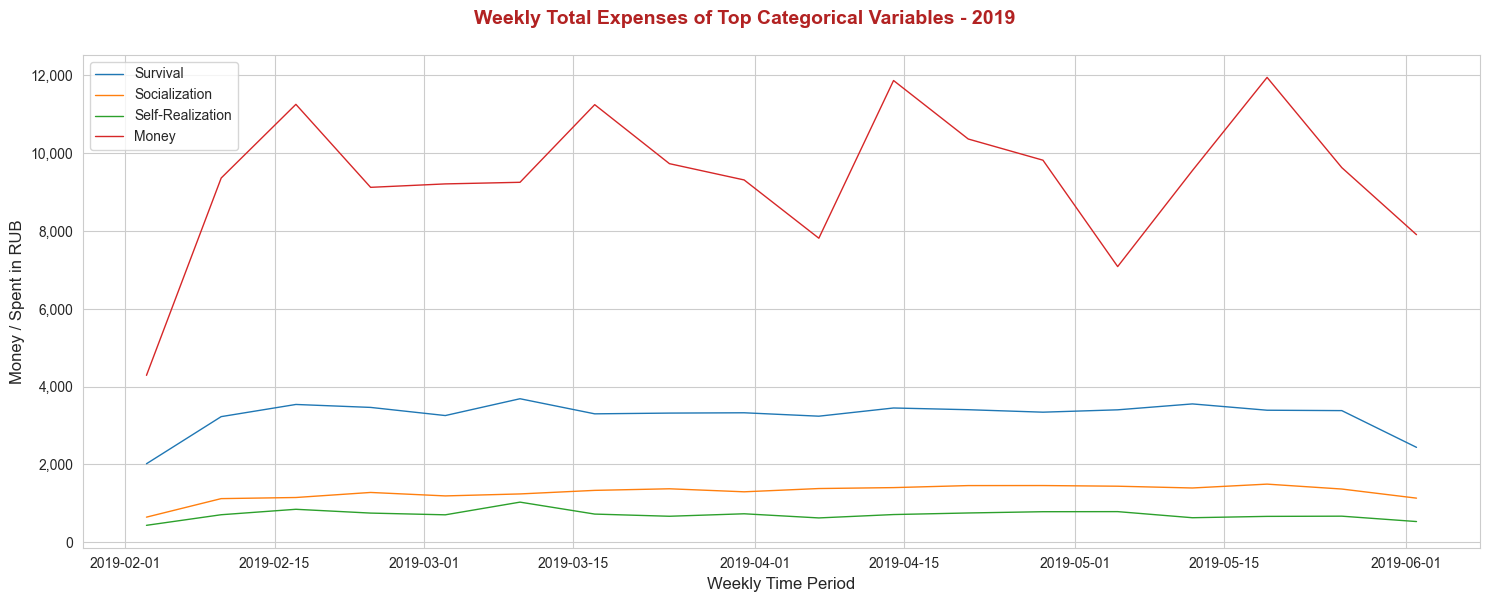

In [ ]:
# plotting the graph

temp_df = working_df_2019.toPandas()

temp_df.Date = pd.to_datetime(temp_df.Date)  # it takes care of chronology(across visualization packages) and assign appropriate x-ticks and intervals

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Money')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Weekly Time Period', fontsize=12)
ax.set_ylabel('Money / Spent in RUB', fontsize=12)

fig.suptitle('Weekly Total Expenses of Top Categorical Variables - 2019', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Weekly_Total_ExpensesofTop_Categorical_Variables_2019.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

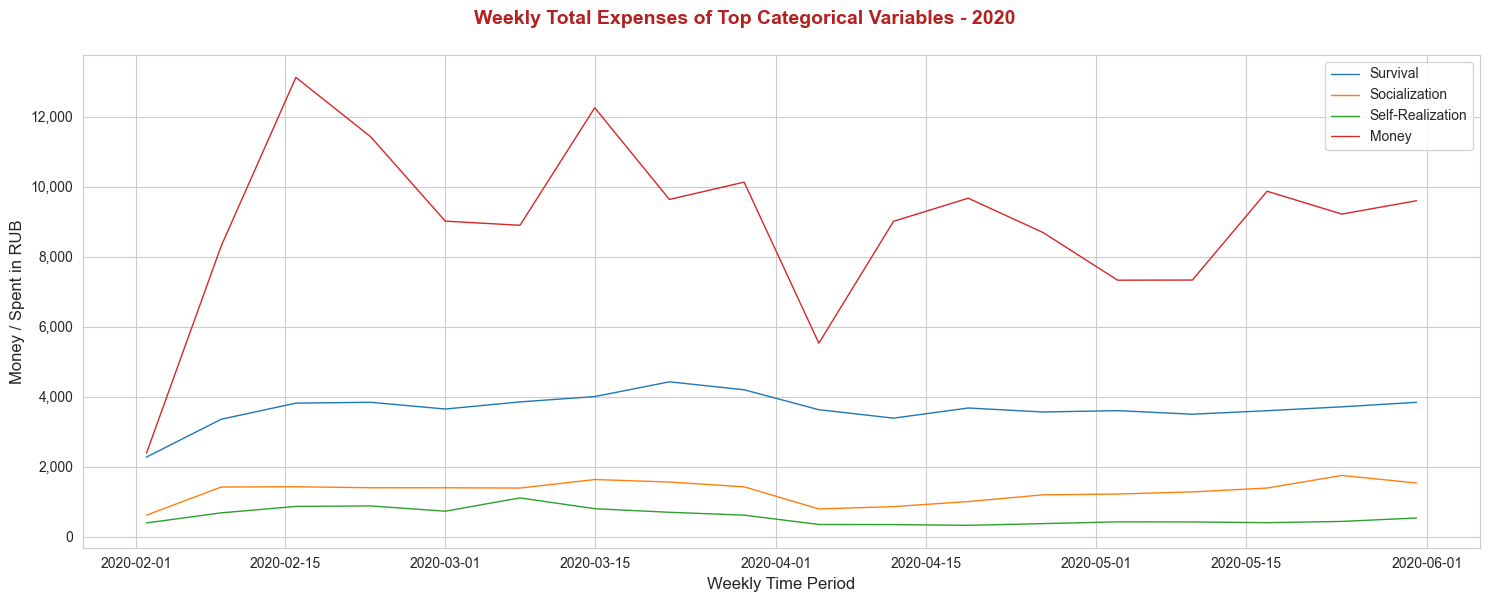

In [ ]:
# plotting the graph

temp_df = working_df_2020.toPandas()

temp_df.Date = pd.to_datetime(temp_df.Date)  # it takes care of chronology(across visualization packages) and assign appropriate x-ticks and intervals

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Money')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Weekly Time Period', fontsize=12)
ax.set_ylabel('Money / Spent in RUB', fontsize=12)

fig.suptitle('Weekly Total Expenses of Top Categorical Variables - 2020', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Weekly_Total_ExpensesofTop_Categorical_Variables_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

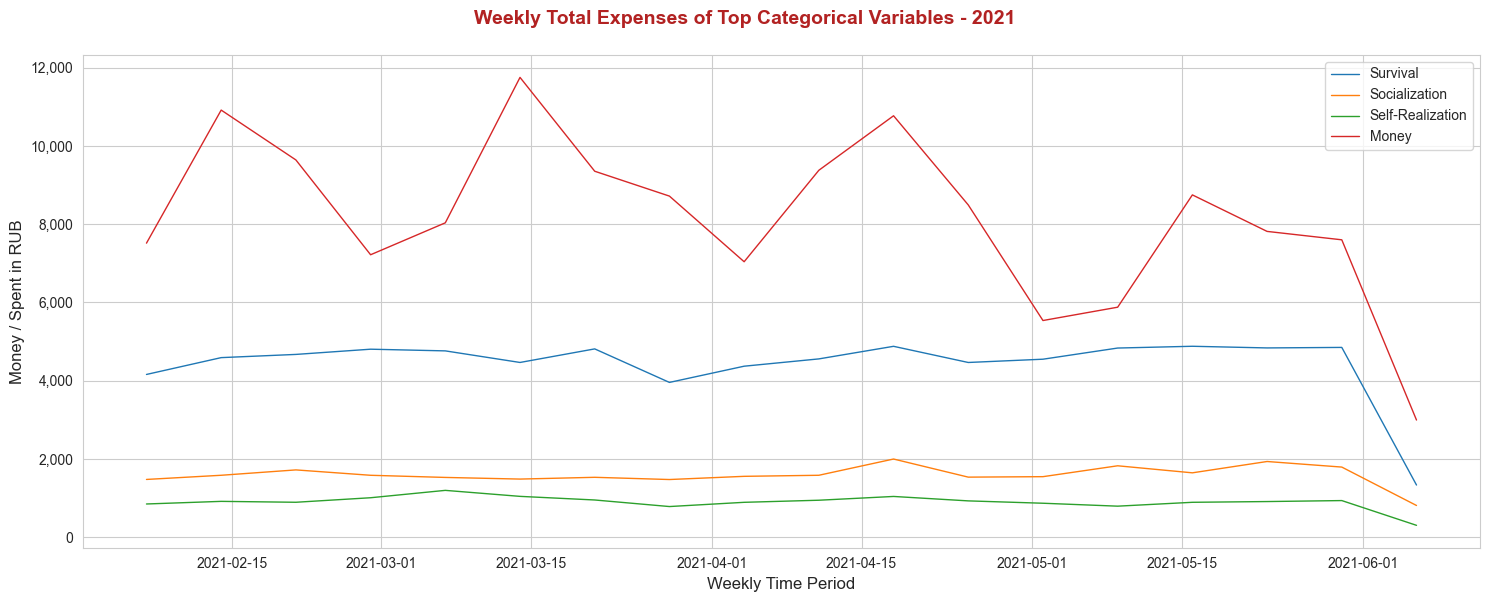

In [ ]:
# plotting the graph

temp_df = working_df_2021.toPandas()

temp_df.Date = pd.to_datetime(temp_df.Date)  # it takes care of chronology(across visualization packages) and assign appropriate x-ticks and intervals

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Money')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Weekly Time Period', fontsize=12)
ax.set_ylabel('Money / Spent in RUB', fontsize=12)

fig.suptitle('Weekly Total Expenses of Top Categorical Variables - 2021', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Weekly_Total_ExpensesofTop_Categorical_Variables_2021.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

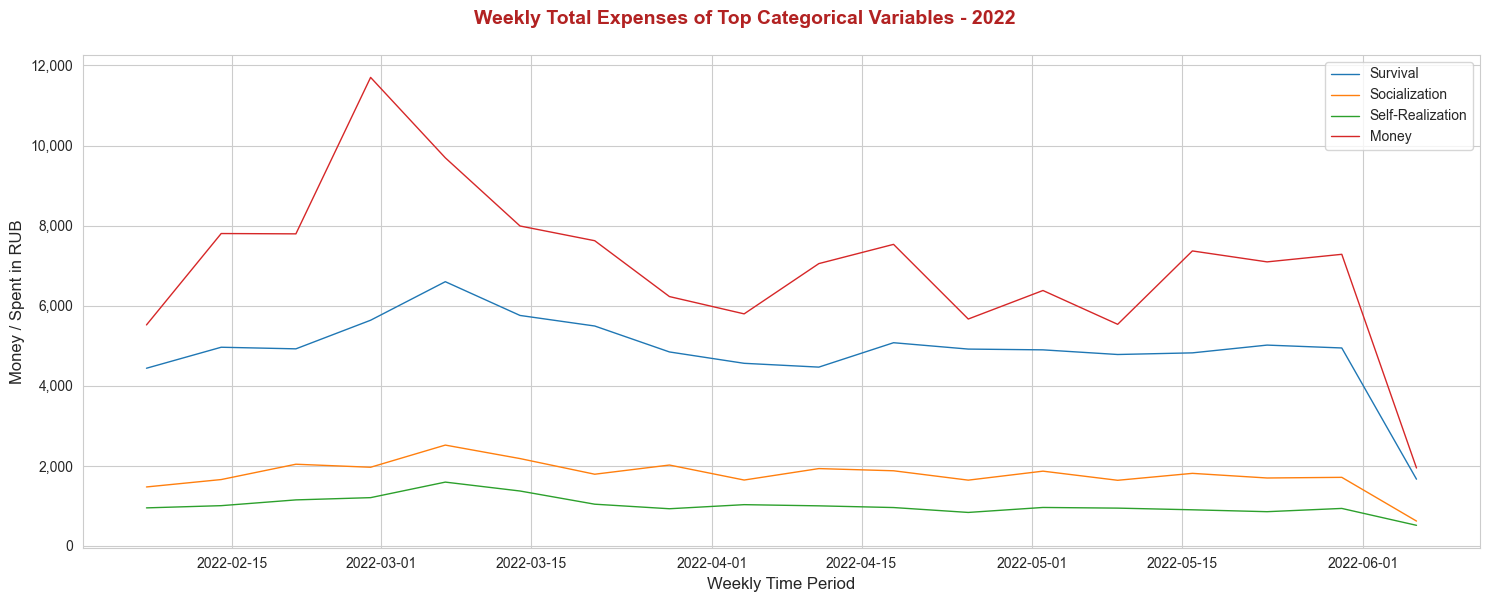

In [ ]:
# plotting the graph

temp_df = working_df_2022.toPandas()

temp_df.Date = pd.to_datetime(temp_df.Date)  # it takes care of chronology(across visualization packages) and assign appropriate x-ticks and intervals

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax, label='Money')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Weekly Time Period', fontsize=12)
ax.set_ylabel('Money / Spent in RUB', fontsize=12)

fig.suptitle('Weekly Total Expenses of Top Categorical Variables - 2022', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Weekly_Total_ExpensesofTop_Categorical_Variables_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

Merging into one graph all weekly total expenses
--- 

'\n# Set X and Y label. Add labelpad so that the text does not overlap the ticks\nax.set_xlabel("The X label", labelpad=20, fontsize=12)\nax.set_ylabel("The Y label", labelpad=40, fontsize=12)\n\n# Set fig legend as you did\nlabels = ["A","B"]\nfig.legend(labels, loc=\'lower center\', ncol=len(labels), bbox_to_anchor=(0.55, 0))\n'

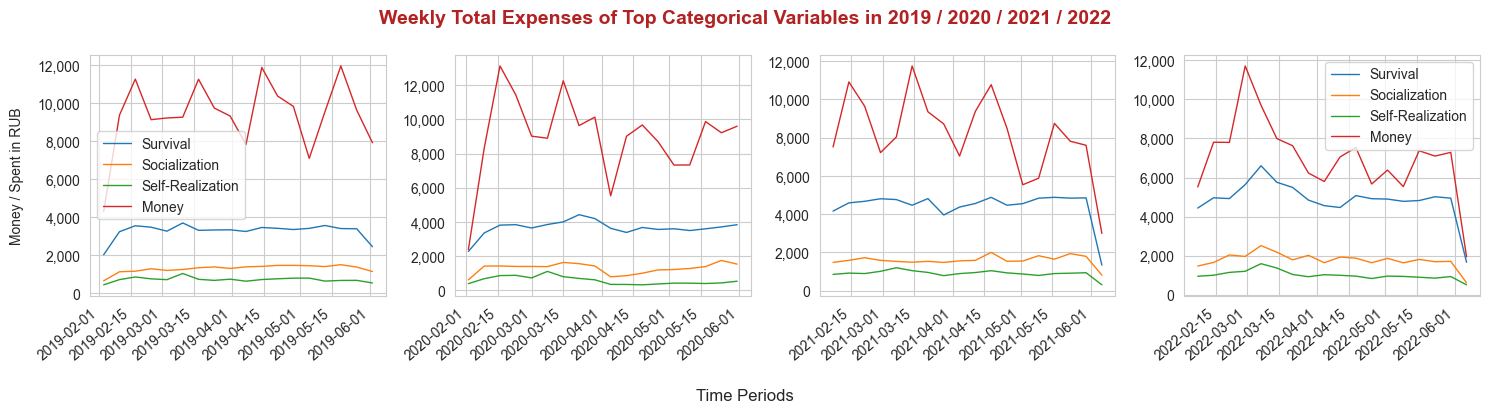

In [ ]:
colors=['blue', 'orange', 'green', 'red']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 4))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        temp_df = working_df_2019.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date)
        sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Survival')
        sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Socialization')
        sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Self-Realization')
        sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Money')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('Money / Spent in RUB', labelpad=10, fontsize=10)   # adding labelpad so that the text does not overlap the ticks
        ax[i].set_xlabel('')

   
    elif i == 1:
        temp_df = working_df_2020.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date)  
        sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
 
    elif i == 2:
        temp_df = working_df_2021.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date) 
        sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i])
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')

    else:
        temp_df = working_df_2022.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date) 
        sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Survival')
        sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Socialization')
        sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Self-Realization')
        sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], ci = None, linewidth=1, ax=ax[i], label='Money')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')


fig.suptitle('Weekly Total Expenses of Top Categorical Variables in 2019 / 2020 / 2021 / 2022', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Time Periods')
plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()



'''
# Set X and Y label. Add labelpad so that the text does not overlap the ticks
ax.set_xlabel("The X label", labelpad=20, fontsize=12)
ax.set_ylabel("The Y label", labelpad=40, fontsize=12)

# Set fig legend as you did
labels = ["A","B"]
fig.legend(labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.55, 0))
'''       

Clustering
---

Clustering is a type of unsupervised learning problem and the main idea is finding similarities between different data points and pair them under the same group in a way that those data points in the same group (cluster) are more like each other than to those in other groups. It is one of the main tasks of exploratory data mining and used in many fields such as bioinformatics, pattern recognition, image analysis, machine learning, etc.

Calculating the difference between March 2019 and March 2020
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_diff_1m_2019_2020').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_diff_1m_2019_2020")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_diff_1m_2019_2020 t order by t.client  '''

working_df_2019_2020 = spark.sql(sql_query)

working_df_2019_2020.show(10)                                               # df_2019_2020.to_csv(r'C:\Users\USER\Desktop\Master Thesis\data_diff.csv', sep='\t', encoding='utf-8', header='true')

+------+--------+-------------+----------------+-------+
|Client|Survival|Socialization|Self-Realization|  Money|
+------+--------+-------------+----------------+-------+
|   224|-55.6472|     -41.0312|         -7.3462| 0.0000|
|  1108| 16.8316|       0.0000|         -0.6263|-8.0457|
|  1117| 18.7343|      -9.9326|         -9.7970|-7.2698|
|  1197| 13.6720|      11.6161|        -89.8943|-0.5758|
|  1223|-11.2744|     -12.1312|         -6.9585|-5.0078|
|  1555| -9.5189|       0.5362|         -1.9717| 2.1119|
|  2005| 41.7101|      -9.3169|          6.6905| 7.6085|
|  2213|-76.2308|      23.5493|          6.5431|46.2330|
|  2677|-11.6185|       0.7141|         -2.3413| 4.4771|
|  2947| 36.5384|      13.8472|        -19.1514| 2.8653|
+------+--------+-------------+----------------+-------+
only showing top 10 rows



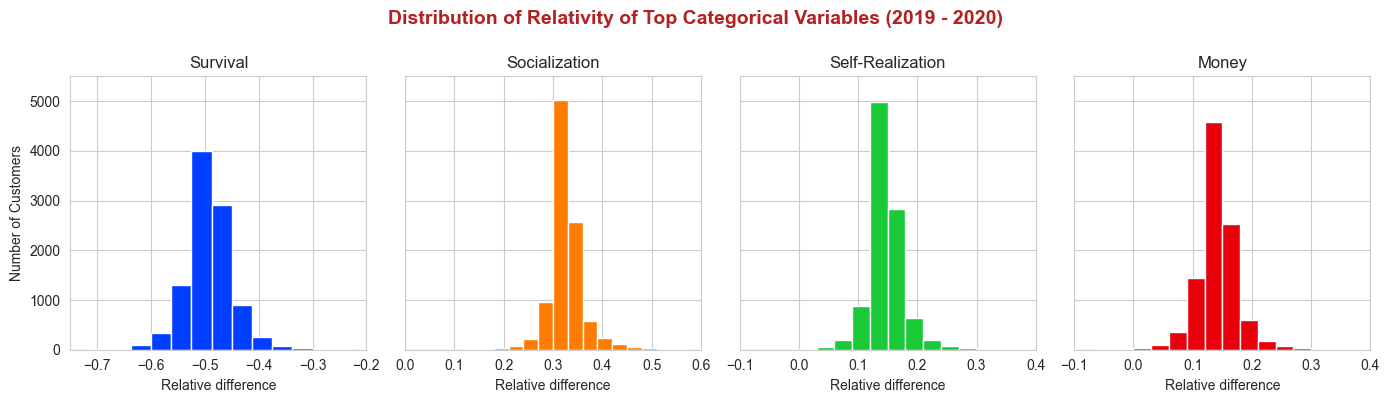

In [ ]:
temp_df_2019_2020 = working_df_2019_2020.toPandas()
temp_df_2019_2020.set_index('Client', inplace=True)

''' Data preprocessing'''
scaler = MinMaxScaler(feature_range=(-0.75, 0.75))
#scaler = MinMaxScaler(feature_range=(-1, 1))
temp_df_2019_2020[['Survival']] = scaler.fit_transform(temp_df_2019_2020[['Survival']])
temp_df_2019_2020[['Socialization']] = scaler.fit_transform(temp_df_2019_2020[['Socialization']])
temp_df_2019_2020[['Self-Realization']] = scaler.fit_transform(temp_df_2019_2020[['Self-Realization']])
temp_df_2019_2020[['Money']] = scaler.fit_transform(temp_df_2019_2020[['Money']])

''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(14, 4))
plt.subplot(141)
plt.hist(temp_df_2019_2020['Survival'], bins=40, color = colors[0])
plt.xlim(-0.75, -0.20)
plt.ylim(0, 5500)
plt.ylabel('Number of Customers')
plt.xlabel('Relative difference')
plt.title('Survival')
plt.subplot(142)
plt.hist(temp_df_2019_2020['Socialization'], bins=50, color = colors[1])
plt.xlim(0.00, 0.60)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Socialization')
plt.subplot(143)
plt.hist(temp_df_2019_2020['Self-Realization'], bins=50, color = colors[2])
plt.xlim(-0.10, 0.40)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Self-Realization')
plt.subplot(144)
plt.hist(temp_df_2019_2020['Money'], bins=50, color = colors[3])
plt.xlim(-0.10, 0.40)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Money')

fig.suptitle("Distribution of Relativity of Top Categorical Variables (2019 - 2020)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Distribution_ofTop_Categorical_Variables_2019_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

In [ ]:

bkm = BisectingKMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42, algorithm='lloyd',)

# Fit the model to our dataset
bkm.fit_predict(temp_df_2019_2020[['Survival', 'Socialization', 'Self-Realization', 'Money']])

# Assign the data back to the df_dates
temp_df_2019_2020['Clusters_2019_2020'] = bkm.labels_

temp_df_2019_2020

Survival  Socialization  Self-Realization  Money  Clusters_2019_2020
Client                                                                       
224       -0.5584         0.2391            0.1226 0.1430                   1
1108      -0.4813         0.3227            0.1412 0.1222                   0
1117      -0.4793         0.3025            0.1159 0.1242                   0
1197      -0.4847         0.3464           -0.1054 0.1415                   1
1223      -0.5112         0.2980            0.1237 0.1301                   0
...           ...            ...               ...    ...                 ...
3560436   -0.4607         0.3925            0.2752 0.1808                   3
3561841   -0.4669         0.3155            0.1778 0.2604                   2
3561945   -0.4844         0.3120            0.1582 0.1323                   0
3562613   -0.4310         0.3834            0.1508 0.0760                   3
3564569   -0.5093         0.3372            0.2132 0.1337                   2

[9961 rows x 5 columns]

In [ ]:
df_2019_2020 = pd.DataFrame(temp_df_2019_2020['Clusters_2019_2020'].value_counts())  # pd.DataFrame creates index by default
df_2019_2020 = df_2019_2020.reset_index() # removing index to the same dataframe/ to a new dataframe
df_2019_2020.columns = ['Clusters_2019_2020', 'Number of Customers for All Top Category']
df_2019_2020


Clusters_2019_2020  Number of Customers for All Top Category
0                   0                                      5260
1                   2                                      3116
2                   1                                       903
3                   3                                       682

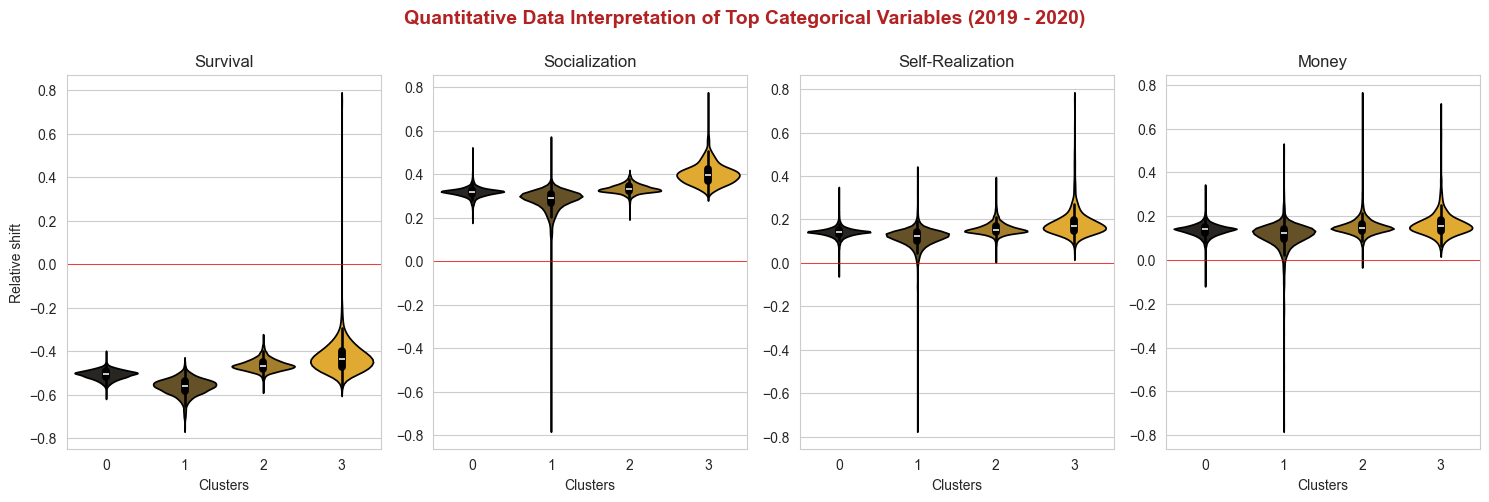

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5)) 
ax = ax.flat
for i,j in enumerate(topcategories): 
        sns.violinplot(data = temp_df_2019_2020, x = 'Clusters_2019_2020', y = temp_df_2019_2020[j], hue = 'Clusters_2019_2020', ax = ax[i], color = '#FDB515', linecolor='black')

        plt.grid(axis='y')
        ax[i].axhline(0., lw=0.5, c='red')
        ax[i].set_xlabel('Clusters')
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].set_ylabel('Relative shift')
            ax[i].set_title('Survival')
        if i == 1:
               ax[i].set_title('Socialization')
               ax[i].set_ylabel('')  
        if i == 2:
               ax[i].set_title('Self-Realization')
               ax[i].set_ylabel('')
        if i == 3:
               ax[i].set_title('Money')
               ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Top Categorical Variables (2019 - 2020)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Calculating the difference between March 2020 and March 2021
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_diff_1m_2020_2021').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_diff_1m_2020_2021")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_diff_1m_2020_2021 t order by t.client  '''

working_df_2020_2021 = spark.sql(sql_query)

working_df_2020_2021.show(10)

+------+--------+-------------+----------------+---------+
|Client|Survival|Socialization|Self-Realization|    Money|
+------+--------+-------------+----------------+---------+
|   224| -7.4652|       1.4042|         12.6764|   0.0000|
|  1108|-28.6816|       0.0000|          0.2972|  -7.4314|
|  1117| -9.2707|      13.7364|          9.4060|  10.1978|
|  1197|  4.5223|      -8.7741|         -3.4425|  -3.3010|
|  1223| 47.0508|      13.5276|          3.2304|  -4.7423|
|  1555| -7.7129|      -0.7262|         -8.8527| -12.3160|
|  2005| 21.2830|      31.0329|          4.5704|  -0.2106|
|  2213|-70.8460|       9.7240|        107.6835|-140.4069|
|  2677| -7.3174|      21.6890|          4.5066|   3.3291|
|  2947|-13.9196|      31.4338|          7.8281| -31.7814|
+------+--------+-------------+----------------+---------+
only showing top 10 rows



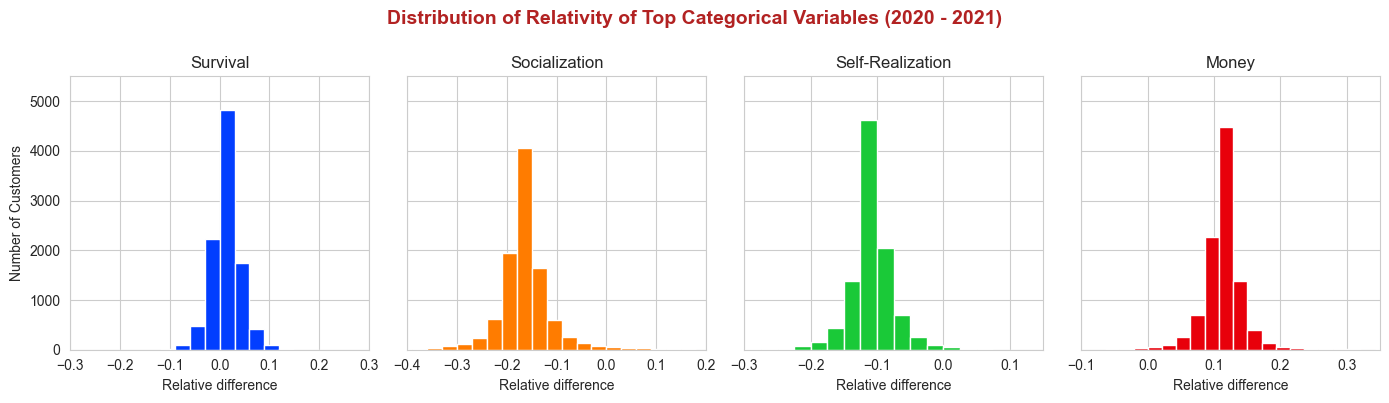

In [ ]:
temp_df_2020_2021 = working_df_2020_2021.toPandas()
temp_df_2020_2021.set_index('Client', inplace=True)

''' Data preprocessing'''
scaler = MinMaxScaler(feature_range=(-0.75, 0.75))
temp_df_2020_2021[['Survival']] = scaler.fit_transform(temp_df_2020_2021[['Survival']])
temp_df_2020_2021[['Socialization']] = scaler.fit_transform(temp_df_2020_2021[['Socialization']])
temp_df_2020_2021[['Self-Realization']] = scaler.fit_transform(temp_df_2020_2021[['Self-Realization']])
temp_df_2020_2021[['Money']] = scaler.fit_transform(temp_df_2020_2021[['Money']])

''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(14, 4))
plt.subplot(141)
plt.hist(temp_df_2020_2021['Survival'], bins=50, color = colors[0])
plt.xlim(-0.30, 0.30)
plt.ylim(0, 5500)
plt.ylabel('Number of Customers')
plt.xlabel('Relative difference')
plt.title('Survival')
plt.subplot(142)
plt.hist(temp_df_2020_2021['Socialization'], bins=50, color = colors[1])
plt.xlim(-0.40, 0.20)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Socialization')
plt.subplot(143)
plt.hist(temp_df_2020_2021['Self-Realization'], bins=60, color = colors[2])
plt.xlim(-0.30, 0.15)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Self-Realization')
plt.subplot(144)
plt.hist(temp_df_2020_2021['Money'], bins=70, color = colors[3])
plt.xlim(-0.10, 0.35)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Money')

fig.suptitle("Distribution of Relativity of Top Categorical Variables (2020 - 2021)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Distribution_ofTop_Categorical_Variables_2020_2021.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

In [ ]:

bkm = BisectingKMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42, algorithm='lloyd',)

# Fit the model to our dataset
bkm.fit_predict(temp_df_2020_2021[['Survival', 'Socialization', 'Self-Realization', 'Money']])

# Assign the data back to the df_dates
temp_df_2020_2021['Clusters_2020_2021'] = bkm.labels_

temp_df_2020_2021

Survival  Socialization  Self-Realization  Money  Clusters_2020_2021
Client                                                                       
224        0.0041        -0.1665           -0.0735 0.1166                   0
1108      -0.0102        -0.1706           -0.1090 0.1016                   0
1117       0.0029        -0.1312           -0.0829 0.1372                   2
1197       0.0122        -0.1958           -0.1198 0.1100                   0
1223       0.0408        -0.1318           -0.1006 0.1071                   2
...           ...            ...               ...    ...                 ...
3560436   -0.0040        -0.1395           -0.2014 0.1158                   0
3561841   -0.0350        -0.1789           -0.1712 0.0316                   0
3561945   -0.0219        -0.1636           -0.1105 0.1242                   0
3562613    0.0147        -0.1590           -0.1116 0.1709                   0
3564569    0.0082        -0.1837           -0.0962 0.1096                   0

[9967 rows x 5 columns]

In [ ]:
df_2020_2021 = pd.DataFrame(temp_df_2020_2021['Clusters_2020_2021'].value_counts())  # pd.DataFrame creates by default index
df_2020_2021 = df_2020_2021.reset_index() # removing index and assigning to the same dataframe/to a new dataframe
df_2020_2021.columns = ['Clusters_2020_2021', 'Number of Customers for All Top Category']
df_2020_2021

Clusters_2020_2021  Number of Customers for All Top Category
0                   0                                      6565
1                   2                                      2274
2                   1                                       862
3                   3                                       266

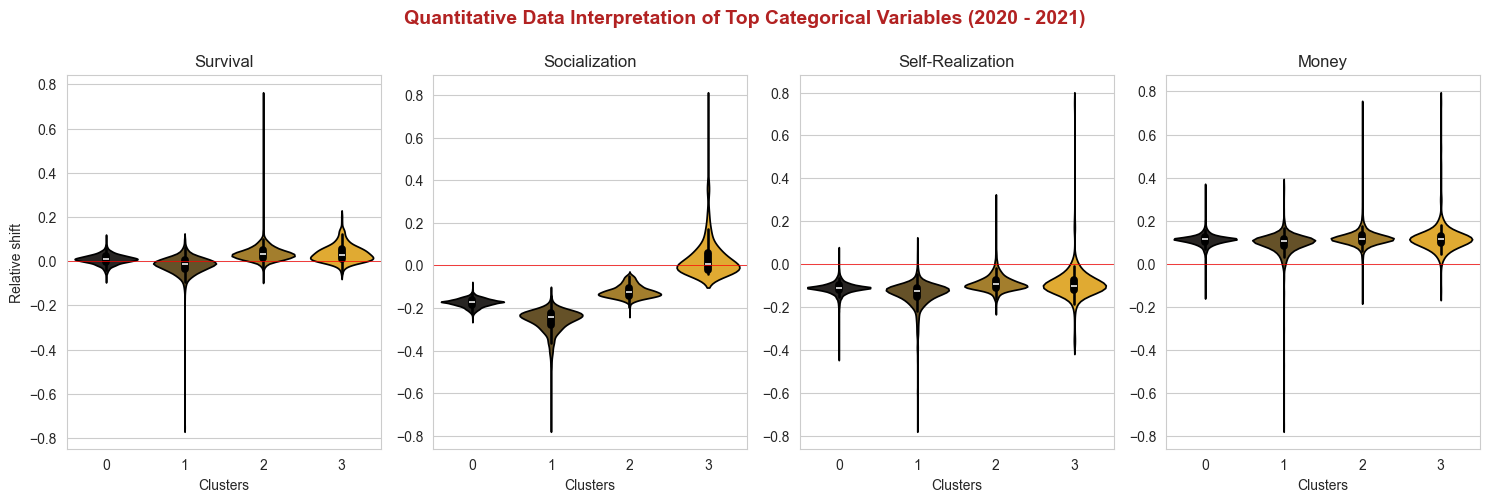

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5)) 
ax = ax.flat
for i,j in enumerate(topcategories): 
        sns.violinplot(data = temp_df_2020_2021, x = 'Clusters_2020_2021', y = temp_df_2020_2021[j], hue = 'Clusters_2020_2021', ax = ax[i], color = '#FDB515', linecolor='black')

        plt.grid(axis='y')
        ax[i].axhline(0., lw=0.5, c='red')
        ax[i].set_xlabel('Clusters')
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].set_ylabel('Relative shift')
            ax[i].set_title('Survival')
        if i == 1:
               ax[i].set_title('Socialization')
               ax[i].set_ylabel('')  
        if i == 2:
               ax[i].set_title('Self-Realization')
               ax[i].set_ylabel('')
        if i == 3:
               ax[i].set_title('Money')
               ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Top Categorical Variables (2020 - 2021)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2020_2021.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Strategical attitude in 2020-2021 according to 2019-2020
---

In [ ]:
# Merging DataFrames on the 'Client' column
merged_df1 = temp_df_2020_2021.merge(temp_df_2019_2020['Clusters_2019_2020'], on='Client',  how='inner')

merged_df1

Survival  Socialization  Self-Realization  Money  Clusters_2020_2021  \
Client                                                                          
224        0.0041        -0.1665           -0.0735 0.1166                   0   
1108      -0.0102        -0.1706           -0.1090 0.1016                   0   
1117       0.0029        -0.1312           -0.0829 0.1372                   2   
1197       0.0122        -0.1958           -0.1198 0.1100                   0   
1223       0.0408        -0.1318           -0.1006 0.1071                   2   
...           ...            ...               ...    ...                 ...   
3560436   -0.0040        -0.1395           -0.2014 0.1158                   0   
3561841   -0.0350        -0.1789           -0.1712 0.0316                   0   
3561945   -0.0219        -0.1636           -0.1105 0.1242                   0   
3562613    0.0147        -0.1590           -0.1116 0.1709                   0   
3564569    0.0082        -0.1837           -0.0962 0.1096                   0   

         Clusters_2019_2020  
Client                       
224                       1  
1108                      0  
1117                      0  
1197                      1  
1223                      0  
...                     ...  
3560436                   3  
3561841                   2  
3561945                   0  
3562613                   3  
3564569                   2  

[9944 rows x 6 columns]

In [ ]:
common_index   = merged_df1[merged_df1['Clusters_2020_2021'] == merged_df1['Clusters_2019_2020']].index
uncommon_index = merged_df1[merged_df1['Clusters_2020_2021'] != merged_df1['Clusters_2019_2020']].index

len(common_index)                       

4313

In [ ]:
merged_df1[merged_df1['Clusters_2020_2021'] == merged_df1['Clusters_2019_2020']]  #meme merged_df1.loc[common_index,:] or temp_df_2020_2021.loc[common_index,:]

Survival  Socialization  Self-Realization   Money  \
Client                                                       
1108      -0.0102        -0.1706           -0.1090  0.1016   
1555       0.0039        -0.1727           -0.1353  0.0918   
2005       0.0235        -0.0815           -0.0967  0.1162   
2947      -0.0003        -0.0804           -0.0874  0.0525   
3845      -0.0046        -0.1687           -0.1054  0.1238   
...           ...            ...               ...     ...   
3548549    0.0410        -0.0982           -0.1327 -0.0012   
3548715   -0.0014        -0.1994           -0.0985  0.1235   
3554064    0.0996        -0.2316           -0.0472  0.1204   
3560021   -0.0076        -0.1837           -0.1191  0.1237   
3561945   -0.0219        -0.1636           -0.1105  0.1242   

         Clusters_2020_2021  Clusters_2019_2020  
Client                                           
1108                      0                   0  
1555                      0                   0  
2005                      2                   2  
2947                      2                   2  
3845                      0                   0  
...                     ...                 ...  
3548549                   2                   2  
3548715                   0                   0  
3554064                   0                   0  
3560021                   0                   0  
3561945                   0                   0  

[4313 rows x 6 columns]

In [ ]:
merged_df1[merged_df1['Clusters_2020_2021'] != merged_df1['Clusters_2019_2020']]  #meme merged_df1.loc[uncommon_index,:] or temp_df_2020_2021.loc[uncommon_index,:]

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224        0.0041        -0.1665           -0.0735  0.1166   
1117       0.0029        -0.1312           -0.0829  0.1372   
1197       0.0122        -0.1958           -0.1198  0.1100   
1223       0.0408        -0.1318           -0.1006  0.1071   
2213      -0.0387        -0.1427            0.1993 -0.1668   
...           ...            ...               ...     ...   
3559291   -0.0221        -0.2290           -0.1336 -0.0096   
3560436   -0.0040        -0.1395           -0.2014  0.1158   
3561841   -0.0350        -0.1789           -0.1712  0.0316   
3562613    0.0147        -0.1590           -0.1116  0.1709   
3564569    0.0082        -0.1837           -0.0962  0.1096   

         Clusters_2020_2021  Clusters_2019_2020  
Client                                           
224                       0                   1  
1117                      2                   0  
1197                      0                   1  
1223                      2                   0  
2213                      2                   0  
...                     ...                 ...  
3559291                   1                   3  
3560436                   0                   3  
3561841                   0                   2  
3562613                   0                   3  
3564569                   0                   2  

[5631 rows x 6 columns]

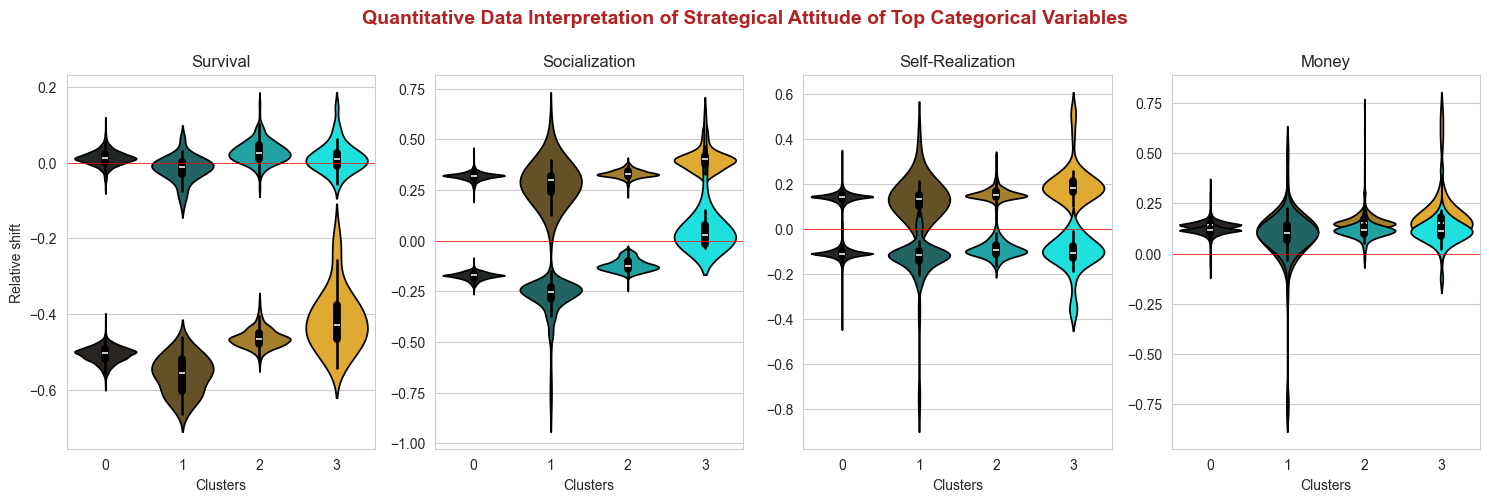

In [ ]:
#      sns.violinplot(data = merged_df1.loc[uncommon_index,:], x = 'Clusters_2019_2020', y = merged_df1.loc[uncommon_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'cyan', linecolor='black')
#      sns.violinplot(data = merged_df1.loc[common_index,:], x = 'Clusters_2020_2021', y = merged_df1.loc[common_index,:][j], hue = 'Clusters_2020_2021', ax = ax[i], color = 'orange', linecolor='black')

topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5)) 
ax = ax.flat
for i,j in enumerate(topcategories):

       sns.violinplot(data = temp_df_2019_2020.loc[common_index,:], x = 'Clusters_2019_2020', y = temp_df_2019_2020.loc[common_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = '#FDB515', linecolor='black')
                  
       sns.violinplot(data = temp_df_2020_2021.loc[common_index,:], x = 'Clusters_2020_2021', y = temp_df_2020_2021.loc[common_index,:][j], hue = 'Clusters_2020_2021', ax = ax[i], color = 'cyan', linecolor='black')
   
       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020_and_2020_2021.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

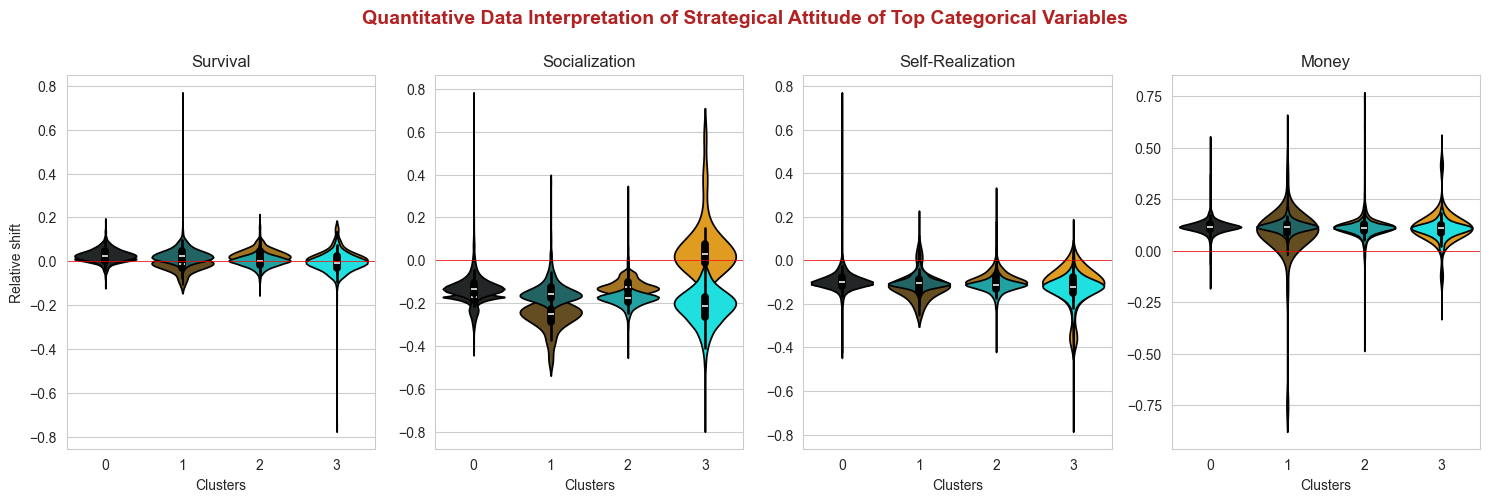

In [ ]:
# from source
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5),)    
ax = ax.flat
for i,j in enumerate(topcategories):
             
       sns.violinplot(data = merged_df1.loc[common_index,:], x = 'Clusters_2020_2021', y = merged_df1.loc[common_index,:][j], hue = 'Clusters_2020_2021', ax = ax[i], color = 'orange', linecolor='black')
      
       sns.violinplot(data = merged_df1.loc[uncommon_index,:], x = 'Clusters_2019_2020', y = merged_df1.loc[uncommon_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'cyan', linecolor='black')


       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')   


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020_and_2020_2021_real.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Calculating the difference between March 2021 and March 2022
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_diff_1m_2021_2022').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_diff_1m_2021_2022")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_diff_1m_2021_2022 t order by t.client  '''

working_df_2021_2022 = spark.sql(sql_query)

working_df_2021_2022.show(10)

+------+--------+-------------+----------------+--------+
|Client|Survival|Socialization|Self-Realization|   Money|
+------+--------+-------------+----------------+--------+
|   224| 19.3360|      31.1131|        -12.6764|  0.0000|
|  1108| 22.2465|       0.0000|          0.6496| -3.8751|
|  1117|-24.4334|      17.1450|         -9.4060|-15.8510|
|  1197| 51.3509|      -2.8420|         -3.7601|  0.0000|
|  1223|-17.2849|     -11.7494|          5.1967| -3.6021|
|  1555| -3.1966|      -1.6524|          2.4757|  0.0000|
|  2005|-40.9865|     -42.3794|        -19.8486|  9.5140|
|  2213|-43.7854|       3.5704|         -3.6450|  7.8129|
|  2677| 18.4023|     -15.1746|          2.0054| -7.8062|
|  2947|-82.1411|     -50.6135|        -14.5206|-16.2974|
+------+--------+-------------+----------------+--------+
only showing top 10 rows



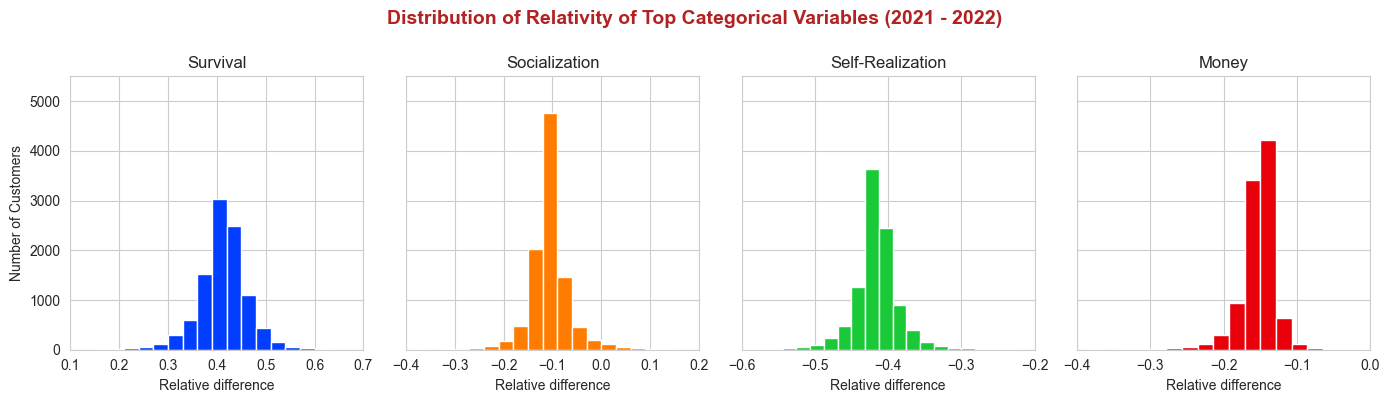

In [ ]:
temp_df_2021_2022 = working_df_2021_2022.toPandas()
temp_df_2021_2022.set_index('Client', inplace=True)

''' Data preprocessing'''
scaler = MinMaxScaler(feature_range=(-0.75, 0.75))
temp_df_2021_2022[['Survival']] = scaler.fit_transform(temp_df_2021_2022[['Survival']])
temp_df_2021_2022[['Socialization']] = scaler.fit_transform(temp_df_2021_2022[['Socialization']])
temp_df_2021_2022[['Self-Realization']] = scaler.fit_transform(temp_df_2021_2022[['Self-Realization']])
temp_df_2021_2022[['Money']] = scaler.fit_transform(temp_df_2021_2022[['Money']])

''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(14, 4))
plt.subplot(141)
plt.hist(temp_df_2021_2022['Survival'], bins=50, color = colors[0])
plt.xlim(0.10, 0.70)
plt.ylim(0, 5500)
plt.ylabel('Number of Customers')
plt.xlabel('Relative difference')
plt.title('Survival')
plt.subplot(142)
plt.hist(temp_df_2021_2022['Socialization'], bins=50, color = colors[1])
plt.xlim(-0.40, 0.20)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Socialization')
plt.subplot(143)
plt.hist(temp_df_2021_2022['Self-Realization'], bins=80, color = colors[2])
plt.xlim(-0.60, -0.20)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Self-Realization')
plt.subplot(144)
plt.hist(temp_df_2021_2022['Money'], bins=70, color = colors[3])
plt.xlim(-0.40, 0.00)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Money')

fig.suptitle("Distribution of Relativity of Top Categorical Variables (2021 - 2022)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Distribution_ofTop_Categorical_Variables_2021_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

In [ ]:

bkm = BisectingKMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42, algorithm='lloyd',)

# Fit the model to our dataset
bkm.fit_predict(temp_df_2021_2022[['Survival', 'Socialization', 'Self-Realization', 'Money']])

# Assign the data back to the df_dates
temp_df_2021_2022['Clusters_2021_2022'] = bkm.labels_

temp_df_2021_2022

Survival  Socialization  Self-Realization   Money  Clusters_2021_2022
Client                                                                        
224        0.4276        -0.0477           -0.4490 -0.1461                   3
1108       0.4306        -0.1098           -0.4141 -0.1530                   2
1117       0.3817        -0.0755           -0.4404 -0.1743                   1
1197       0.4611        -0.1154           -0.4257 -0.1461                   2
1223       0.3892        -0.1332           -0.4022 -0.1525                   1
...           ...            ...               ...     ...                 ...
3560436    0.4136        -0.1087           -0.4553 -0.1812                   1
3561841    0.3992        -0.1000           -0.4183 -0.1462                   1
3561945    0.4931        -0.1111           -0.4084 -0.1459                   2
3562613    0.4288        -0.2411           -0.4153 -0.1847                   1
3564569    0.4195        -0.1185           -0.4645 -0.1399                   1

[9942 rows x 5 columns]

In [ ]:
df_2021_2022 = pd.DataFrame(temp_df_2021_2022['Clusters_2021_2022'].value_counts())  # pd.DataFrame creates by default index
df_2021_2022 = df_2021_2022.reset_index() # removing index to the same dataframe / to a new dataframe
df_2021_2022.columns = ['Clusters_2021_2022', 'Number of Customers for All Top Category']
df_2021_2022

Clusters_2021_2022  Number of Customers for All Top Category
0                   2                                      4641
1                   1                                      3830
2                   0                                       828
3                   3                                       643

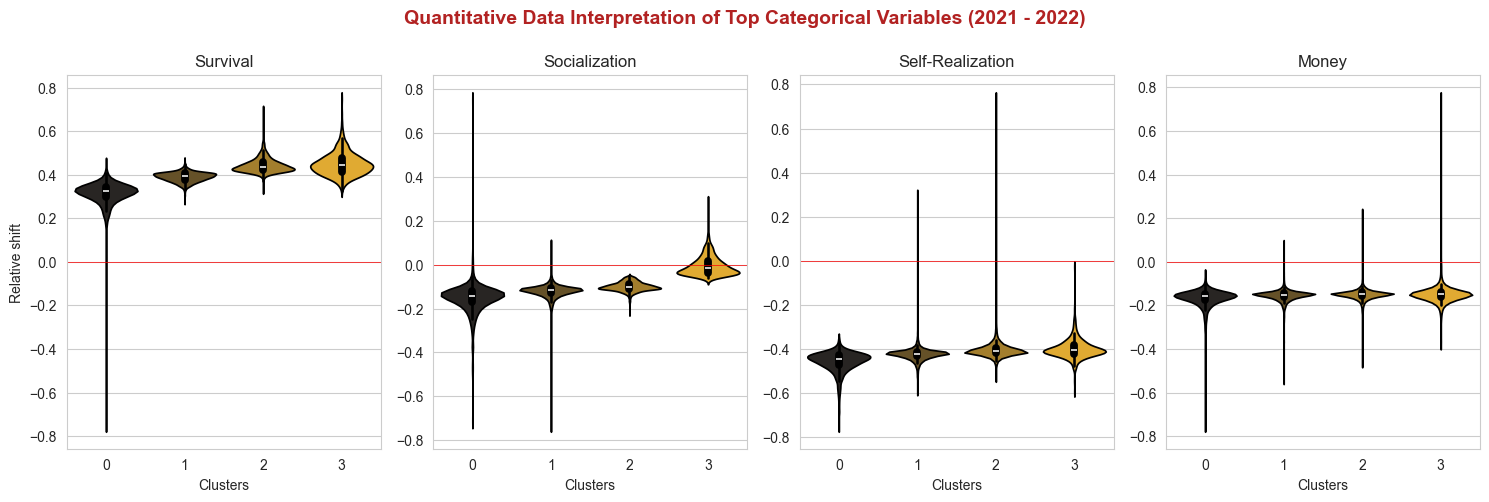

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5)) 
ax = ax.flat
for i,j in enumerate(topcategories): 
        sns.violinplot(data = temp_df_2021_2022, x = 'Clusters_2021_2022', y = temp_df_2021_2022[j], hue = 'Clusters_2021_2022', ax = ax[i], color = '#FDB515', linecolor='black')

        plt.grid(axis='y')
        ax[i].axhline(0., lw=0.5, c='red')
        ax[i].set_xlabel('Clusters')
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].set_ylabel('Relative shift')
            ax[i].set_title('Survival')
        if i == 1:
               ax[i].set_title('Socialization')
               ax[i].set_ylabel('')  
        if i == 2:
               ax[i].set_title('Self-Realization')
               ax[i].set_ylabel('')
        if i == 3:
               ax[i].set_title('Money')
               ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Top Categorical Variables (2021 - 2022)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2021_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Calculating the difference between March 2019 and March 2022
---

In [ ]:
''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_diff_1m_2019_2022').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_diff_1m_2019_2022")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_diff_1m_2019_2022 t order by t.client  '''

working_df_2019_2022 = spark.sql(sql_query)

working_df_2019_2022.show(10)

+------+---------+-------------+----------------+--------+
|Client| Survival|Socialization|Self-Realization|   Money|
+------+---------+-------------+----------------+--------+
|   224| -43.7764|      -8.5139|         -7.3462|  0.0000|
|  1108|  10.3965|       0.0000|          0.3205|-19.3522|
|  1117| -14.9698|      20.9488|         -9.7970|-12.9230|
|  1197|  69.5452|       0.0000|        -97.0969| -3.8768|
|  1223|  18.4915|     -10.3530|          1.4686|-13.3522|
|  1555| -20.4284|      -1.8424|         -8.3487|-10.2041|
|  2005|  22.0066|     -20.6634|         -8.5877| 16.9119|
|  2213|-190.8622|      36.8437|        110.5816|-86.3610|
|  2677|  -0.5336|       7.2285|          4.1707|  0.0000|
|  2947| -59.5223|      -5.3325|        -25.8439|-45.2135|
+------+---------+-------------+----------------+--------+
only showing top 10 rows



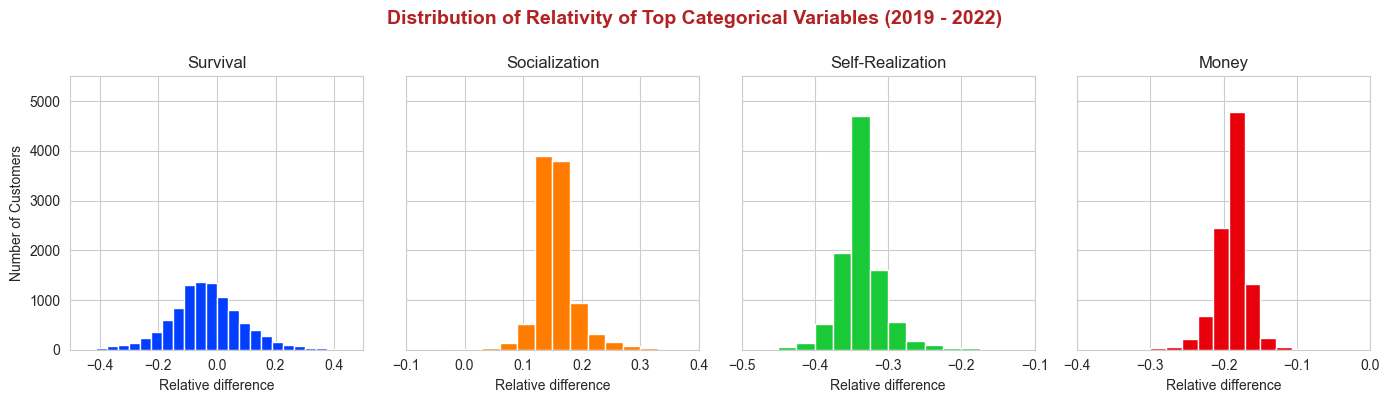

In [ ]:
temp_df_2019_2022 = working_df_2019_2022.toPandas()
temp_df_2019_2022.set_index('Client', inplace=True)

''' Data preprocessing'''
scaler = MinMaxScaler(feature_range=(-0.75, 0.75))
temp_df_2019_2022[['Survival']] = scaler.fit_transform(temp_df_2019_2022[['Survival']])
temp_df_2019_2022[['Socialization']] = scaler.fit_transform(temp_df_2019_2022[['Socialization']])
temp_df_2019_2022[['Self-Realization']] = scaler.fit_transform(temp_df_2019_2022[['Self-Realization']])
temp_df_2019_2022[['Money']] = scaler.fit_transform(temp_df_2019_2022[['Money']])

''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(14, 4))
plt.subplot(141)
plt.hist(temp_df_2019_2022['Survival'], bins=40, color = colors[0])
plt.xlim(-0.50, 0.50)
plt.ylim(0, 5500)
plt.ylabel('Number of Customers')
plt.xlabel('Relative difference')
plt.title('Survival')
plt.subplot(142)
plt.hist(temp_df_2019_2022['Socialization'], bins=50, color = colors[1])
plt.xlim(-0.10, 0.40)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Socialization')
plt.subplot(143)
plt.hist(temp_df_2019_2022['Self-Realization'], bins=60, color = colors[2])
plt.xlim(-0.50, -0.10)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Self-Realization')
plt.subplot(144)
plt.hist(temp_df_2019_2022['Money'], bins=70, color = colors[3])
plt.xlim(-0.40, 0.00)
plt.ylim(0, 5500)
plt.xlabel('Relative difference')
plt.title('Money')

fig.suptitle("Distribution of Relativity of Top Categorical Variables (2019 - 2022)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Distribution_ofTop_Categorical_Variables_2019_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

In [ ]:
bkm = BisectingKMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42, algorithm='lloyd',)

# Fit the model to our dataset
bkm.fit_predict(temp_df_2019_2022[['Survival', 'Socialization', 'Self-Realization', 'Money']])

# Assign the data back to the df_dates
temp_df_2019_2022['Clusters_2019_2022'] = bkm.labels_

temp_df_2019_2022

Survival  Socialization  Self-Realization   Money  Clusters_2019_2022
Client                                                                        
224       -0.1844         0.1362           -0.3618 -0.1780                   0
1108      -0.0543         0.1481           -0.3424 -0.2100                   1
1117      -0.1152         0.1774           -0.3680 -0.1994                   1
1197       0.0878         0.1481           -0.5890 -0.1844                   2
1223      -0.0349         0.1336           -0.3395 -0.2001                   1
...           ...            ...               ...     ...                 ...
3560436   -0.0246         0.2118           -0.3410 -0.1872                   2
3561841   -0.1819         0.1459           -0.3677 -0.1727                   0
3561945    0.0405         0.1432           -0.3226 -0.1785                   2
3562613    0.1440         0.1034           -0.3370 -0.2124                   3
3564569   -0.0772         0.1456           -0.3139 -0.1839                   1

[9937 rows x 5 columns]

In [ ]:
df_2019_2022 = pd.DataFrame(temp_df_2019_2022['Clusters_2019_2022'].value_counts())  # pd.DataFrame creates by default index
df_2019_2022 = df_2019_2022.reset_index() # removing index to the same dataframe / to a new dataframe
df_2019_2022.columns = ['Clusters_2019_2022', 'Number of Customers for All Top Category']
df_2019_2022

Clusters_2019_2022  Number of Customers for All Top Category
0                   1                                      4156
1                   2                                      3300
2                   0                                      1480
3                   3                                      1001

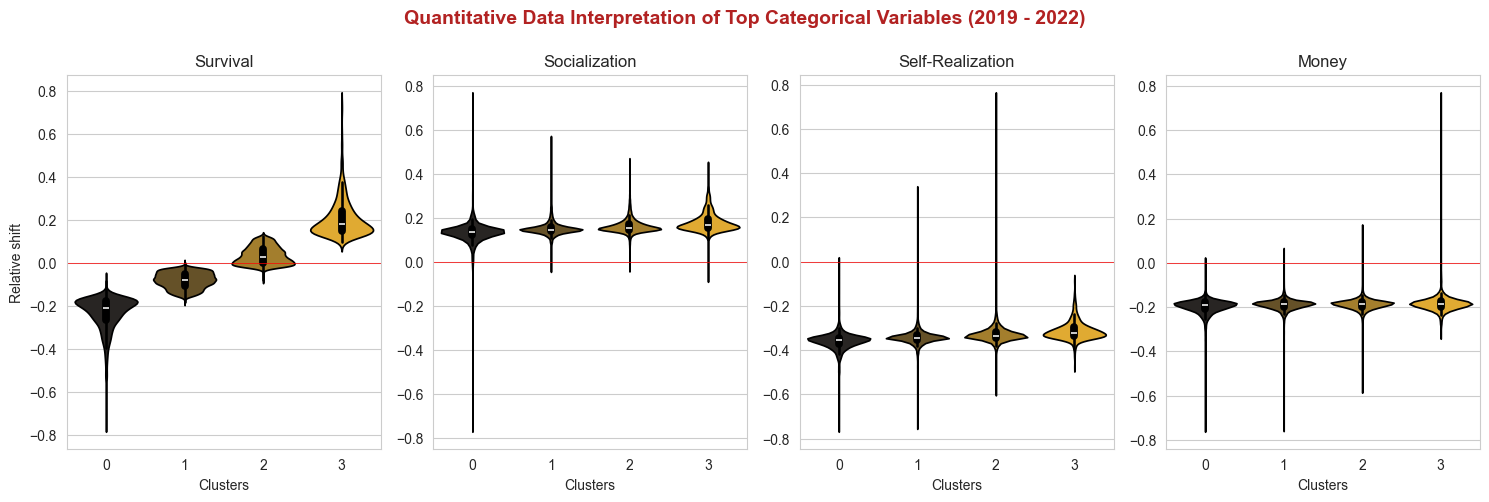

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5)) 
ax = ax.flat
for i,j in enumerate(topcategories): 
        sns.violinplot(data = temp_df_2019_2022, x = 'Clusters_2019_2022', y = temp_df_2019_2022[j], hue = 'Clusters_2019_2022', ax = ax[i], color = '#FDB515', linecolor='black')

        plt.grid(axis='y')
        ax[i].axhline(0., lw=0.5, c='red')
        ax[i].set_xlabel('Clusters')
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].set_ylabel('Relative shift')
            ax[i].set_title('Survival')
        if i == 1:
               ax[i].set_title('Socialization')
               ax[i].set_ylabel('')  
        if i == 2:
               ax[i].set_title('Self-Realization')
               ax[i].set_ylabel('')
        if i == 3:
               ax[i].set_title('Money')
               ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Top Categorical Variables (2019 - 2022)", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Strategical attitude in 2021-2022 according to 2020-2021
---

In [ ]:
# Merging DataFrames on the 'Client' column
merged_df2 = temp_df_2021_2022.merge(temp_df_2020_2021['Clusters_2020_2021'], on='Client',  how='inner')

merged_df2

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224        0.4276        -0.0477           -0.4490 -0.1461   
1108       0.4306        -0.1098           -0.4141 -0.1530   
1117       0.3817        -0.0755           -0.4404 -0.1743   
1197       0.4611        -0.1154           -0.4257 -0.1461   
1223       0.3892        -0.1332           -0.4022 -0.1525   
...           ...            ...               ...     ...   
3560436    0.4136        -0.1087           -0.4553 -0.1812   
3561841    0.3992        -0.1000           -0.4183 -0.1462   
3561945    0.4931        -0.1111           -0.4084 -0.1459   
3562613    0.4288        -0.2411           -0.4153 -0.1847   
3564569    0.4195        -0.1185           -0.4645 -0.1399   

         Clusters_2021_2022  Clusters_2020_2021  
Client                                           
224                       3                   0  
1108                      2                   0  
1117                      1                   2  
1197                      2                   0  
1223                      1                   2  
...                     ...                 ...  
3560436                   1                   0  
3561841                   1                   0  
3561945                   2                   0  
3562613                   1                   0  
3564569                   1                   0  

[9926 rows x 6 columns]

In [ ]:
common_index   = merged_df2[merged_df2['Clusters_2021_2022'] == merged_df2['Clusters_2020_2021']].index
uncommon_index = merged_df2[merged_df2['Clusters_2021_2022'] != merged_df2['Clusters_2020_2021']].index

len(common_index)    

1271

In [ ]:
merged_df2[merged_df2['Clusters_2021_2022'] == merged_df2['Clusters_2020_2021']]  # same as merged_df2.loc[common_index,:]

Survival  Socialization  Self-Realization   Money  \
Client                                                       
4885       0.4267        -0.0804           -0.4021 -0.1471   
5737       0.3875        -0.0939           -0.4251 -0.1308   
6285       0.3944         0.0786           -0.3678 -0.1945   
6404       0.4073        -0.1133           -0.4158 -0.1461   
13870      0.4454        -0.1310           -0.4097 -0.1461   
...           ...            ...               ...     ...   
3543340    0.3940        -0.1163           -0.4074 -0.1612   
3544561    0.4393        -0.1071           -0.3704 -0.2440   
3545900    0.4138        -0.0973           -0.4012 -0.1514   
3554064    0.3101        -0.0285           -0.4491 -0.1474   
3559291    0.3657        -0.1259           -0.4230 -0.1712   

         Clusters_2021_2022  Clusters_2020_2021  
Client                                           
4885                      2                   2  
5737                      1                   1  
6285                      3                   3  
6404                      1                   1  
13870                     2                   2  
...                     ...                 ...  
3543340                   1                   1  
3544561                   2                   2  
3545900                   2                   2  
3554064                   0                   0  
3559291                   1                   1  

[1271 rows x 6 columns]

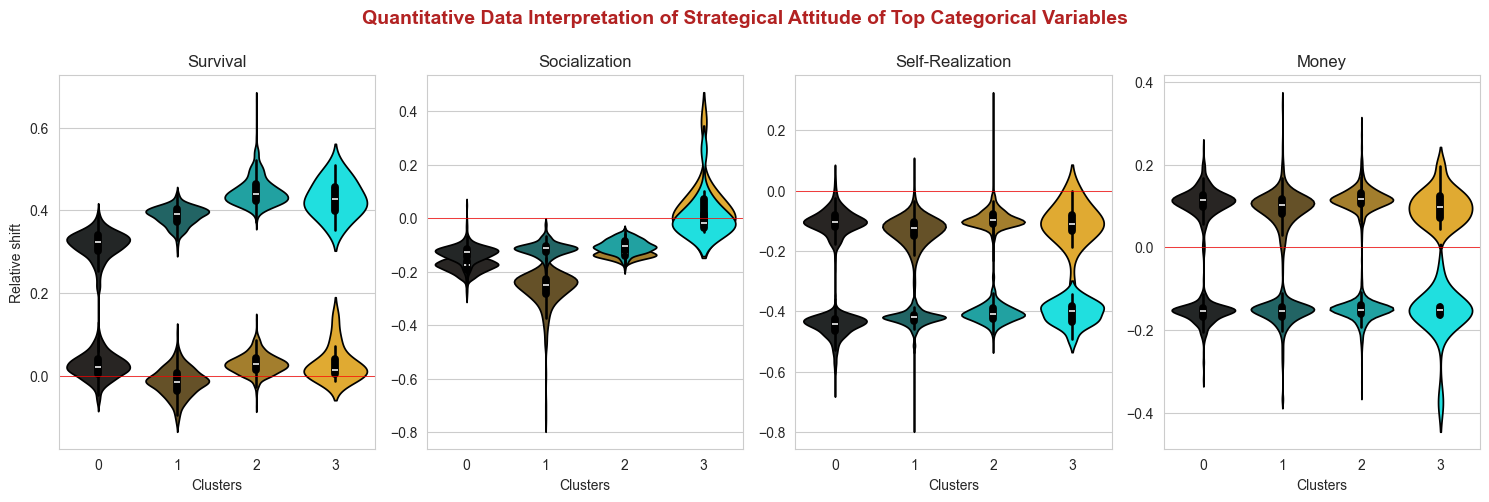

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5)) 
ax = ax.flat
for i,j in enumerate(topcategories):

       sns.violinplot(data = temp_df_2020_2021.loc[common_index,:], x = 'Clusters_2020_2021', y = temp_df_2020_2021.loc[common_index,:][j], hue = 'Clusters_2020_2021', ax = ax[i], color = '#FDB515', linecolor='black')
   
       sns.violinplot(data = temp_df_2021_2022.loc[common_index,:], x = 'Clusters_2021_2022', y = temp_df_2021_2022.loc[common_index,:][j], hue = 'Clusters_2021_2022', ax = ax[i], color = 'cyan', linecolor='black')


       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2020_2021_and_2021_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

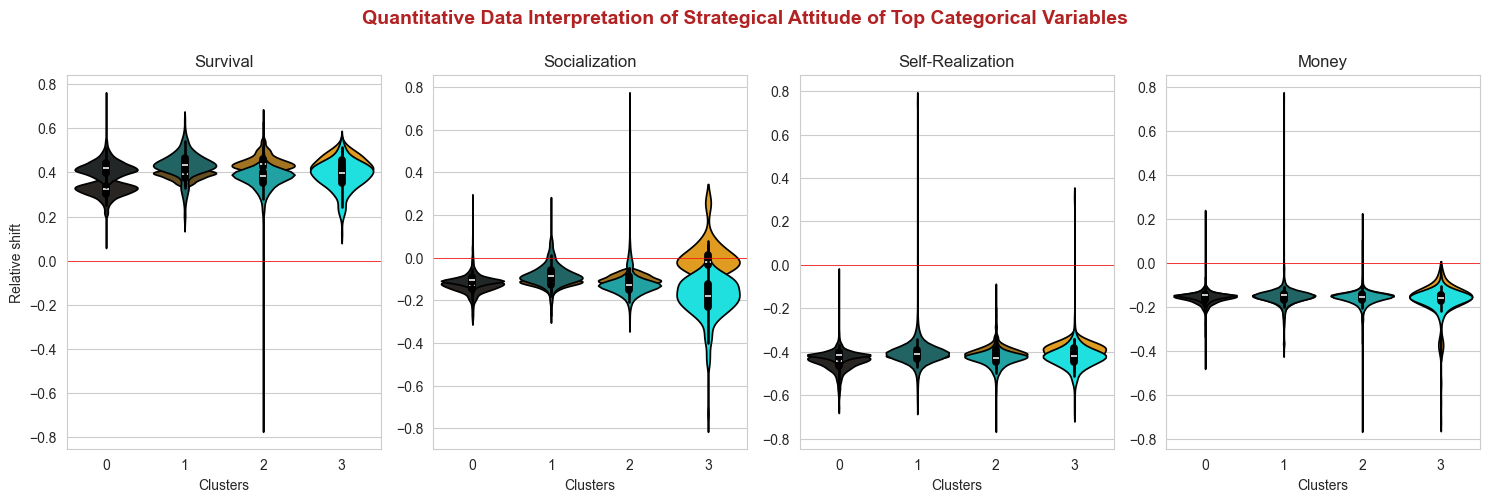

In [ ]:
# from source
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5),)  
ax = ax.flat
for i,j in enumerate(topcategories):
             
       sns.violinplot(data = merged_df2.loc[common_index,:], x = 'Clusters_2020_2021', y = merged_df2.loc[common_index,:][j], hue = 'Clusters_2020_2021', ax = ax[i], color = 'orange', linecolor='black')
      
       sns.violinplot(data = merged_df2.loc[uncommon_index,:], x = 'Clusters_2020_2021', y = merged_df2.loc[uncommon_index,:][j], hue = 'Clusters_2020_2021', ax = ax[i], color = 'cyan', linecolor='black')

       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')   


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2020_2021_and_2021_2022_real.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Strategical attitude in 2021-2022 according to 2019-2020
---

In [ ]:

# Merging DataFrames on the 'Client' column
merged_df3 = temp_df_2021_2022.merge(temp_df_2019_2020['Clusters_2019_2020'], on='Client',  how='inner')

merged_df3

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224        0.4276        -0.0477           -0.4490 -0.1461   
1108       0.4306        -0.1098           -0.4141 -0.1530   
1117       0.3817        -0.0755           -0.4404 -0.1743   
1197       0.4611        -0.1154           -0.4257 -0.1461   
1223       0.3892        -0.1332           -0.4022 -0.1525   
...           ...            ...               ...     ...   
3560436    0.4136        -0.1087           -0.4553 -0.1812   
3561841    0.3992        -0.1000           -0.4183 -0.1462   
3561945    0.4931        -0.1111           -0.4084 -0.1459   
3562613    0.4288        -0.2411           -0.4153 -0.1847   
3564569    0.4195        -0.1185           -0.4645 -0.1399   

         Clusters_2021_2022  Clusters_2019_2020  
Client                                           
224                       3                   1  
1108                      2                   0  
1117                      1                   0  
1197                      2                   1  
1223                      1                   0  
...                     ...                 ...  
3560436                   1                   3  
3561841                   1                   2  
3561945                   2                   0  
3562613                   1                   3  
3564569                   1                   2  

[9904 rows x 6 columns]

In [ ]:
common_index   = merged_df3[merged_df3['Clusters_2021_2022'] == merged_df3['Clusters_2019_2020']].index
uncommon_index = merged_df3[merged_df3['Clusters_2021_2022'] != merged_df3['Clusters_2019_2020']].index

len(common_index)    

2155

In [ ]:
merged_df3[merged_df3['Clusters_2021_2022'] != merged_df3['Clusters_2019_2020']]  # same as merged_df3.loc[common_index,:]

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224        0.4276        -0.0477           -0.4490 -0.1461   
1108       0.4306        -0.1098           -0.4141 -0.1530   
1117       0.3817        -0.0755           -0.4404 -0.1743   
1197       0.4611        -0.1154           -0.4257 -0.1461   
1223       0.3892        -0.1332           -0.4022 -0.1525   
...           ...            ...               ...     ...   
3560436    0.4136        -0.1087           -0.4553 -0.1812   
3561841    0.3992        -0.1000           -0.4183 -0.1462   
3561945    0.4931        -0.1111           -0.4084 -0.1459   
3562613    0.4288        -0.2411           -0.4153 -0.1847   
3564569    0.4195        -0.1185           -0.4645 -0.1399   

         Clusters_2021_2022  Clusters_2019_2020  
Client                                           
224                       3                   1  
1108                      2                   0  
1117                      1                   0  
1197                      2                   1  
1223                      1                   0  
...                     ...                 ...  
3560436                   1                   3  
3561841                   1                   2  
3561945                   2                   0  
3562613                   1                   3  
3564569                   1                   2  

[7749 rows x 6 columns]

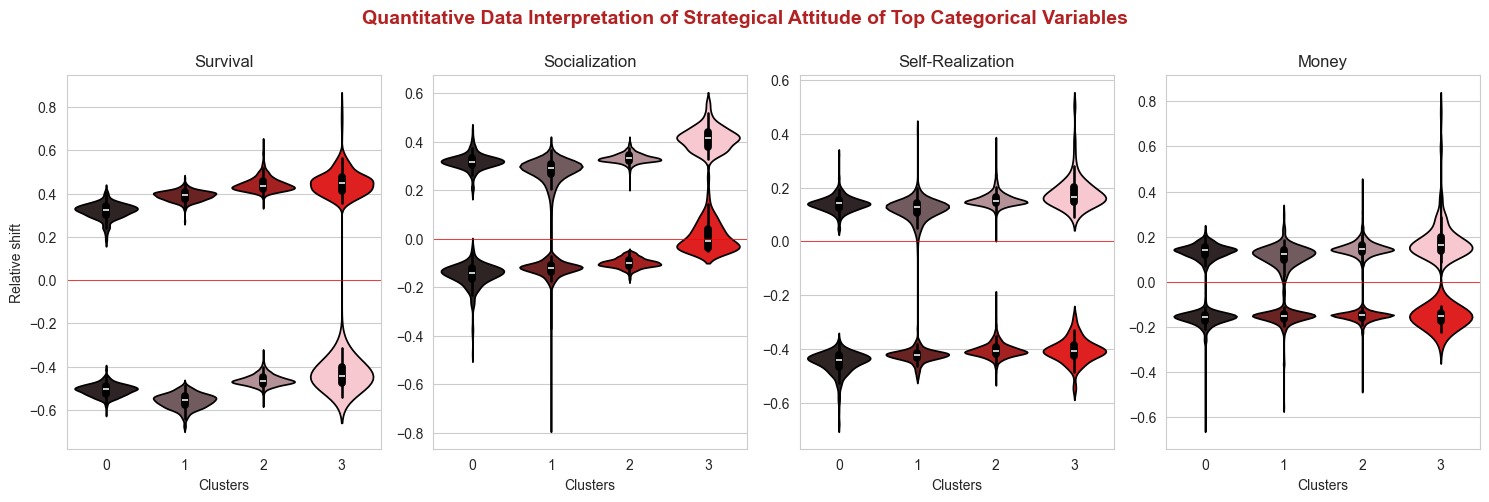

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5),) 
ax = ax.flat
for i,j in enumerate(topcategories):

       sns.violinplot(data = temp_df_2019_2020.loc[common_index,:], x = 'Clusters_2019_2020', y = temp_df_2019_2020.loc[common_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'pink', linecolor='black')
   
       sns.violinplot(data = temp_df_2021_2022.loc[common_index,:], x = 'Clusters_2021_2022', y = temp_df_2021_2022.loc[common_index,:][j], hue = 'Clusters_2021_2022', ax = ax[i], color = 'red', linecolor='black')


       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')   


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020_and_2021_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

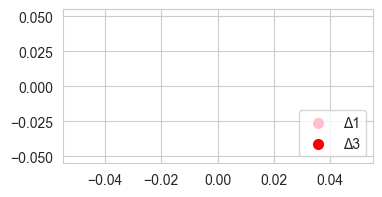

In [ ]:
plt.figure(figsize=(4,2))    
plt.scatter(None, None, c='pink', label='Δ1', lw=2)
plt.scatter(None, None, c='red', label='Δ3', lw=2)
plt.legend(loc=4, fontsize = '10')
plt.show()

---

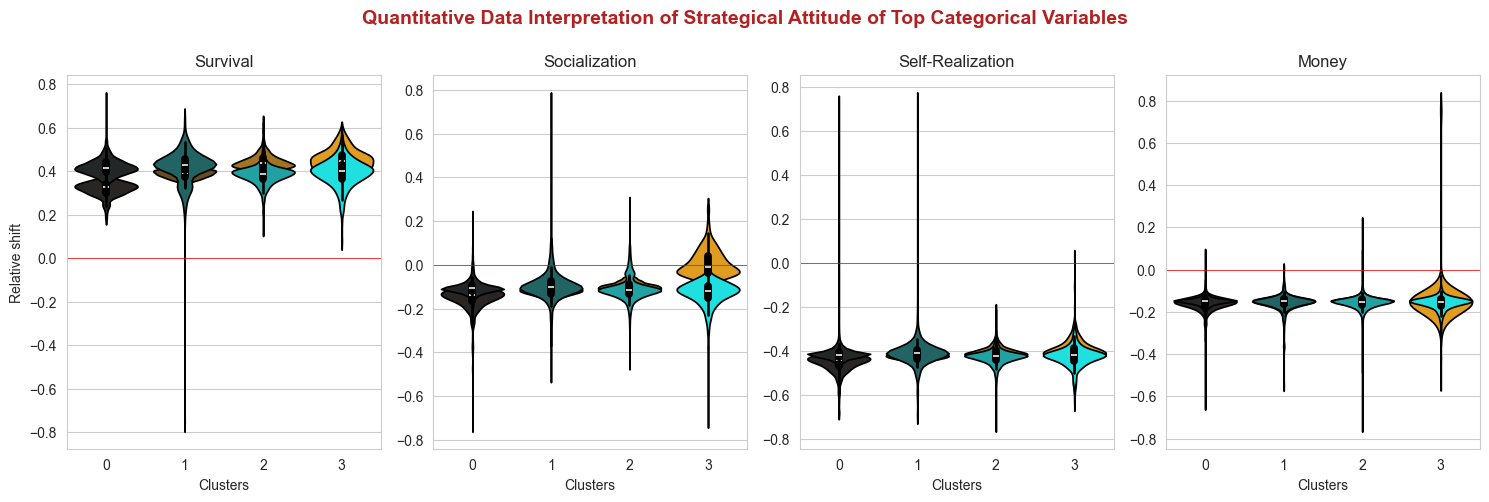

In [ ]:
# from source
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5),) 
ax = ax.flat
for i,j in enumerate(topcategories):
             
       sns.violinplot(data = merged_df3.loc[common_index,:], x = 'Clusters_2019_2020', y = merged_df3.loc[common_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'orange', linecolor='black')
      
       sns.violinplot(data = merged_df3.loc[uncommon_index,:], x = 'Clusters_2019_2020', y = merged_df3.loc[uncommon_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'cyan', linecolor='black')


       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')   


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020_and_2021_2022_real.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Strategical attitude in 2019-2022 according to 2019-2020
---

In [ ]:
# Merging DataFrames on the 'Client' column
merged_df4 = temp_df_2019_2022.merge(temp_df_2019_2020['Clusters_2019_2020'], on='Client',  how='inner')

merged_df4

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224       -0.1844         0.1362           -0.3618 -0.1780   
1108      -0.0543         0.1481           -0.3424 -0.2100   
1117      -0.1152         0.1774           -0.3680 -0.1994   
1197       0.0878         0.1481           -0.5890 -0.1844   
1223      -0.0349         0.1336           -0.3395 -0.2001   
...           ...            ...               ...     ...   
3560436   -0.0246         0.2118           -0.3410 -0.1872   
3561841   -0.1819         0.1459           -0.3677 -0.1727   
3561945    0.0405         0.1432           -0.3226 -0.1785   
3562613    0.1440         0.1034           -0.3370 -0.2124   
3564569   -0.0772         0.1456           -0.3139 -0.1839   

         Clusters_2019_2022  Clusters_2019_2020  
Client                                           
224                       0                   1  
1108                      1                   0  
1117                      1                   0  
1197                      2                   1  
1223                      1                   0  
...                     ...                 ...  
3560436                   2                   3  
3561841                   0                   2  
3561945                   2                   0  
3562613                   3                   3  
3564569                   1                   2  

[9921 rows x 6 columns]

In [ ]:
common_index   = merged_df4[merged_df4['Clusters_2019_2022'] == merged_df4['Clusters_2019_2020']].index
uncommon_index = merged_df4[merged_df4['Clusters_2019_2022'] != merged_df4['Clusters_2019_2020']].index

len(common_index)   

2568

In [ ]:
merged_df4[merged_df4['Clusters_2019_2022'] != merged_df4['Clusters_2019_2020']]  # same as merged_df4.loc[uncommon_index,:]

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224       -0.1844         0.1362           -0.3618 -0.1780   
1108      -0.0543         0.1481           -0.3424 -0.2100   
1117      -0.1152         0.1774           -0.3680 -0.1994   
1197       0.0878         0.1481           -0.5890 -0.1844   
1223      -0.0349         0.1336           -0.3395 -0.2001   
...           ...            ...               ...     ...   
3559291   -0.0588         0.1801           -0.3298 -0.1915   
3560436   -0.0246         0.2118           -0.3410 -0.1872   
3561841   -0.1819         0.1459           -0.3677 -0.1727   
3561945    0.0405         0.1432           -0.3226 -0.1785   
3564569   -0.0772         0.1456           -0.3139 -0.1839   

         Clusters_2019_2022  Clusters_2019_2020  
Client                                           
224                       0                   1  
1108                      1                   0  
1117                      1                   0  
1197                      2                   1  
1223                      1                   0  
...                     ...                 ...  
3559291                   1                   3  
3560436                   2                   3  
3561841                   0                   2  
3561945                   2                   0  
3564569                   1                   2  

[7353 rows x 6 columns]

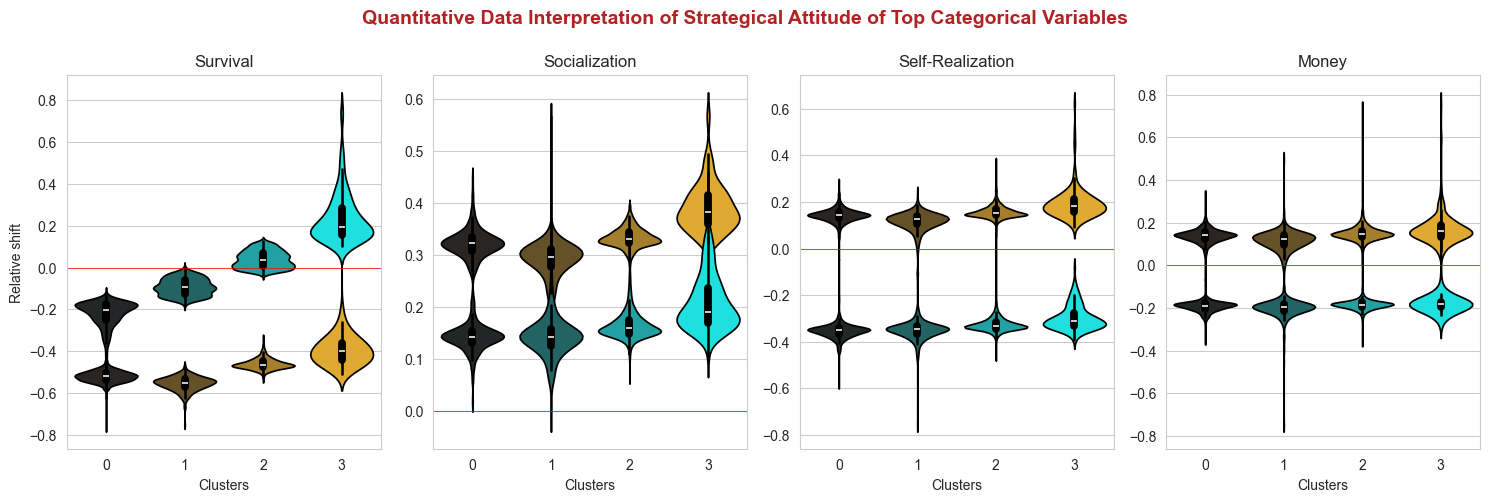

In [ ]:
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5),) 
ax = ax.flat
for i,j in enumerate(topcategories):

       sns.violinplot(data = temp_df_2019_2020.loc[common_index,:], x = 'Clusters_2019_2020', y = temp_df_2019_2020.loc[common_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = '#FDB515', linecolor='black')
   
       sns.violinplot(data = temp_df_2019_2022.loc[common_index,:], x = 'Clusters_2019_2022', y = temp_df_2019_2022.loc[common_index,:][j], hue = 'Clusters_2019_2022', ax = ax[i], color = 'cyan', linecolor='black')


       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')   


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020_and_2019_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

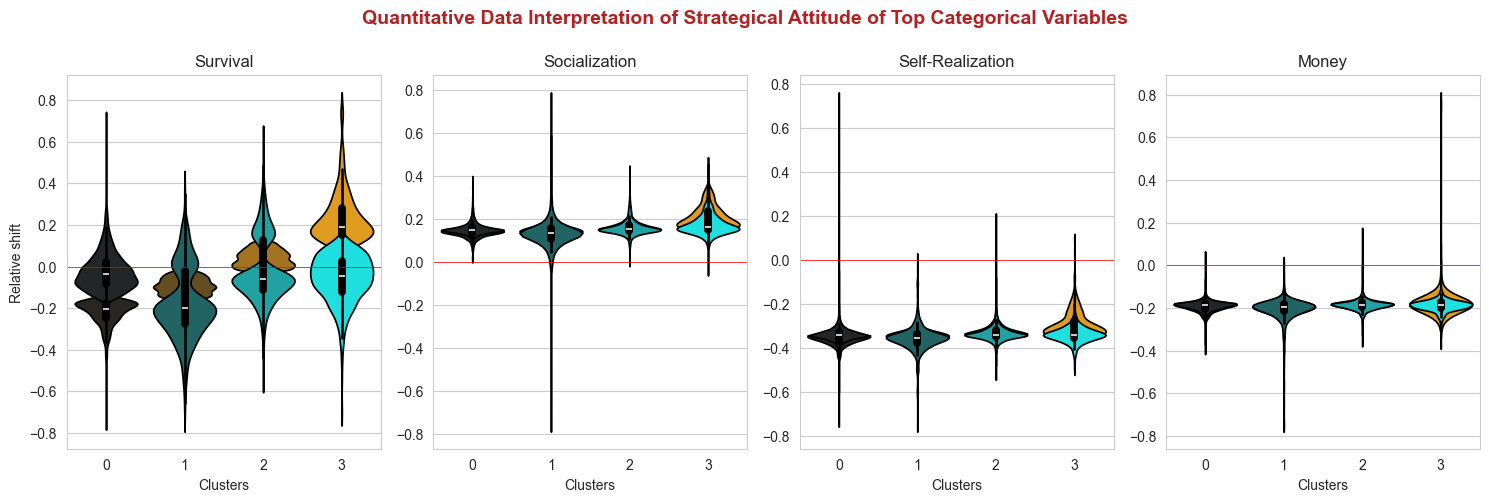

In [ ]:
# from source
topcategories=['Survival', 'Socialization', 'Self-Realization', 'Money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5),) 
ax = ax.flat
for i,j in enumerate(topcategories):
             
       sns.violinplot(data = merged_df4.loc[common_index,:], x = 'Clusters_2019_2020', y = merged_df4.loc[common_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'orange', linecolor='black')
      
       sns.violinplot(data = merged_df4.loc[uncommon_index,:], x = 'Clusters_2019_2020', y = merged_df4.loc[uncommon_index,:][j], hue = 'Clusters_2019_2020', ax = ax[i], color = 'cyan', linecolor='black')


       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')  


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2019_2020_and_2019_2022_real.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Prediction using PySpark
---

In [ ]:
''' 
    [col('table_a.'+xx) for xx in table_a.columns] : all columns in table_a
    [col('table_b.col_1'), col('table_b.col_2')] : some columns of table_b

'''

temp_df = temp_df_2019_2020.reset_index()
temp_df_2020 = spark.createDataFrame(temp_df, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2019_2020'])

df1 = working_df_2020.alias('df1')
df2 = temp_df_2020.alias('df2')

temp_df = df1.join(df2, on = col('df1.Client') == col('df2.Client'), how = 'inner')                    
joined_df = temp_df.select([col('df1.'+xx) for xx in df1.columns] + [col('df2.Clusters_2019_2020')])
#joined_df = temp_df.select([col('df1.Date')] + [col('df2.'+xx) for xx in df2.columns])

joined_df.show(10)



+----------+-------+----------+-------------+----------------+----------+------------------+
|      Date| Client|  Survival|Socialization|Self-Realization|     Money|Clusters_2019_2020|
+----------+-------+----------+-------------+----------------+----------+------------------+
|2020-05-24|2795694| 1649.4500|    1575.7800|          0.0000|    0.0000|                 0|
|2020-04-19|1690373|    0.0000|       0.0000|          0.0000|27500.0000|                 3|
|2020-04-05|2263739| 2038.5700|       0.0000|       1431.0000|  500.0000|                 2|
|2020-03-15|2245710| 2833.0300|       0.0000|          0.0000|    0.0000|                 2|
|2020-04-05| 736223| 9549.3600|       0.0000|          0.0000|    0.0000|                 2|
|2020-05-31|3189019|28673.7300|       0.0000|          0.0000|    0.0000|                 0|
|2020-05-31|3339713|  542.5900|       0.0000|          0.0000| 2500.0000|                 0|
|2020-03-22|2161320| 2913.3900|    4809.3300|       1239.6000|    0.00

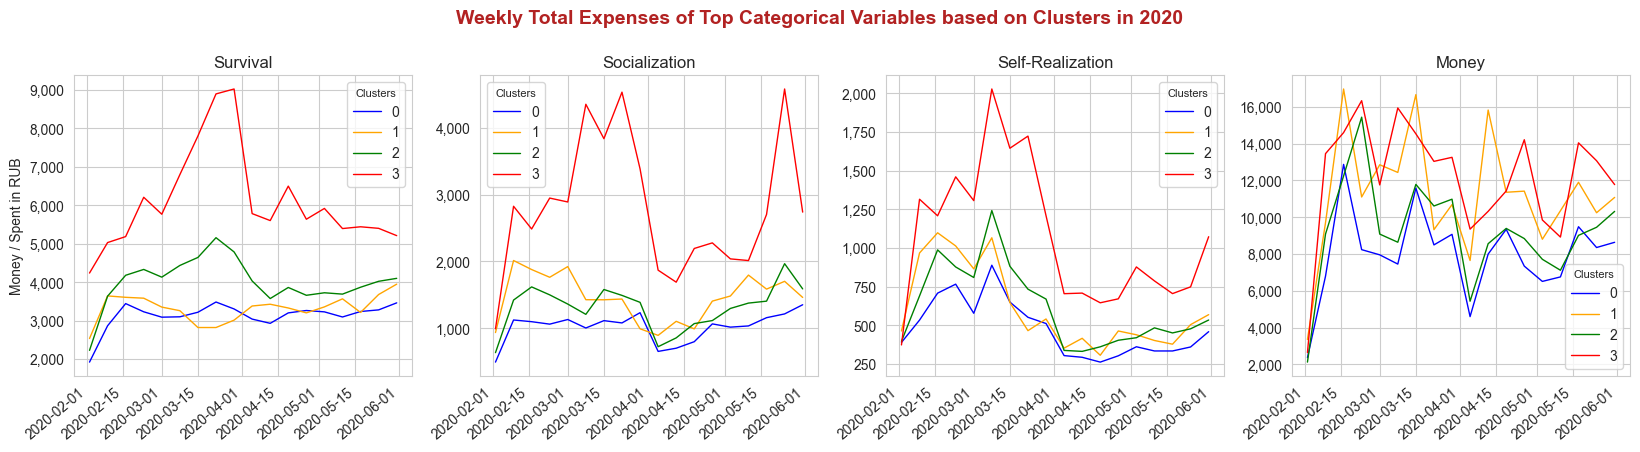

In [ ]:
colors = ['blue', 'orange', 'green', 'red']
pal = sns.color_palette(colors, 4)


fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16.5, 4.5))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date)
        sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], hue = temp_df['Clusters_2019_2020'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('Money / Spent in RUB', fontsize=10)
        ax[i].set_title('Survival')
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') # for legend text
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') # for legend title
        sns.move_legend(ax[i], title='Clusters', loc='best') 
        ax[i].set_xlabel('')
   
    elif i == 1:
        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date)  
        sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], hue = temp_df['Clusters_2019_2020'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_title('Socialization')
        #ax[i].get_legend().set_visible(False)
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
 
    elif i == 2:
        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date) 
        sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], hue = temp_df['Clusters_2019_2020'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_title('Self-Realization')
        #ax[i].get_legend().set_visible(False)
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')        
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')

    else:

        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date) 
        sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], hue = temp_df['Clusters_2019_2020'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_title('Money')
        #ax[i].get_legend().set_visible(False)
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')


fig.suptitle('Weekly Total Expenses of Top Categorical Variables based on Clusters in 2020', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_on_Based_Clusters_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()


---

In [ ]:
temp_df = temp_df_2021_2022.reset_index()
temp_df_2022 = spark.createDataFrame(temp_df, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2021_2022'])

df1 = working_df_2022.alias('df1')
df2 = temp_df_2022.alias('df2')

temp_df = df1.join(df2, on = col('df1.Client') == col('df2.Client'), how = 'inner')                    
joined_df = temp_df.select([col('df1.'+xx) for xx in df1.columns] + [col('df2.Clusters_2021_2022')])

joined_df.show(10)

+----------+-------+----------+-------------+----------------+-----------+------------------+
|      Date| Client|  Survival|Socialization|Self-Realization|      Money|Clusters_2021_2022|
+----------+-------+----------+-------------+----------------+-----------+------------------+
|2022-05-02|2589364| 2299.9300|    3820.0000|          0.0000|     0.0000|                 0|
|2022-04-04|3255869| 2025.3200|       0.0000|          0.0000|   500.0000|                 1|
|2022-04-18|3255869| 2212.4200|     743.6000|       1000.0000| 20000.0000|                 1|
|2022-04-11|2798735| 3151.6300|       0.0000|          0.0000|  7500.0000|                 2|
|2022-03-07|2798735| 2060.4100|    1696.1000|          0.0000|100000.0000|                 2|
|2022-05-30|1778403|    0.0000|       0.0000|          0.0000|236000.0000|                 0|
|2022-05-23|3189019|28761.1600|    1919.0000|          0.0000|     0.0000|                 2|
|2022-05-02|2617665| 9771.5900|    2343.4400|          0.000

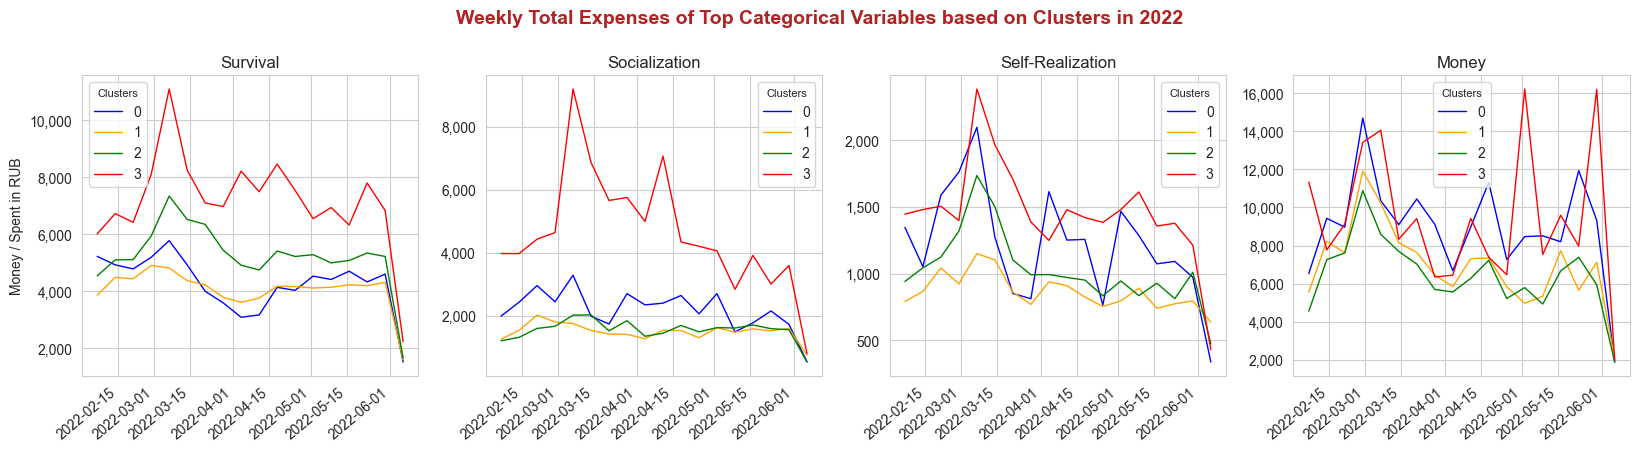

In [ ]:
colors = ['blue', 'orange', 'green', 'red']
pal = sns.color_palette(colors, 4)


fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16.5, 4.5))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date)
        sns.lineplot(data=temp_df, y=temp_df['Survival'], x=temp_df['Date'], hue = temp_df['Clusters_2021_2022'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('Money / Spent in RUB', fontsize=10)
        ax[i].set_title('Survival')
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') # for legend text
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') # for legend title
        sns.move_legend(ax[i], title='Clusters', loc='best') 
        ax[i].set_xlabel('')
   
    elif i == 1:
        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date)  
        sns.lineplot(data=temp_df, y=temp_df['Socialization'], x=temp_df['Date'], hue = temp_df['Clusters_2021_2022'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_title('Socialization')
        #ax[i].get_legend().set_visible(False)
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
 
    elif i == 2:
        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date) 
        sns.lineplot(data=temp_df, y=temp_df['Self-Realization'], x=temp_df['Date'], hue = temp_df['Clusters_2021_2022'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_title('Self-Realization')
        #ax[i].get_legend().set_visible(False)
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')        
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')

    else:

        temp_df = joined_df.toPandas()
        temp_df.Date = pd.to_datetime(temp_df.Date) 
        sns.lineplot(data=temp_df, y=temp_df['Money'], x=temp_df['Date'], hue = temp_df['Clusters_2021_2022'], ci = None, linewidth=1, ax=ax[i], palette=pal)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_title('Money')
        #ax[i].get_legend().set_visible(False)
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')


fig.suptitle('Weekly Total Expenses of Top Categorical Variables based on Clusters in 2022', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_on_Based_Clusters_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()


---

Using sankey diagram to demostrate the migration between clusters
---

In [ ]:
temp_df3 = merged_df3

temp_df3 = temp_df3.reset_index()
temp_df3 = spark.createDataFrame(temp_df3, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2021_2022', 'Clusters_2019_2020'])

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
temp_df3.createOrReplaceTempView('temp_df3')

''' writing the dml '''
sql_query = ''' select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 0 and t.Clusters_2021_2022 = 0
                group by t.Clusters_2019_2020

                union all
                
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 0 and t.Clusters_2021_2022 = 1
                group by t.Clusters_2019_2020

                union all
                
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 0 and t.Clusters_2021_2022 = 2
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 0 and t.Clusters_2021_2022 = 3
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 1 and t.Clusters_2021_2022 = 0
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 1 and t.Clusters_2021_2022 = 1
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 1 and t.Clusters_2021_2022 = 2
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 1 and t.Clusters_2021_2022 = 3
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 2 and t.Clusters_2021_2022 = 0
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 2 and t.Clusters_2021_2022 = 1
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 2 and t.Clusters_2021_2022 = 2
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 2 and t.Clusters_2021_2022 = 3
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 3 and t.Clusters_2021_2022 = 0
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 3 and t.Clusters_2021_2022 = 1
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 3 and t.Clusters_2021_2022 = 2
                group by t.Clusters_2019_2020
                union all
                select 
                         t.Clusters_2019_2020 as from_cluster_2019_2020
                       , max(t.Clusters_2021_2022) as to_cluster_2021_2022 
                       , count(t.Clusters_2021_2022) as migrated_clients
                from temp_df3 t  
                where t.Clusters_2019_2020 = 3 and t.Clusters_2021_2022 = 3
                group by t.Clusters_2019_2020               
            '''


temp_df3 = spark.sql(sql_query)

temp_df3.show()


+----------------------+--------------------+----------------+
|from_cluster_2019_2020|to_cluster_2021_2022|migrated_clients|
+----------------------+--------------------+----------------+
|                     0|                   0|             315|
|                     0|                   1|            2065|
|                     0|                   2|            2578|
|                     0|                   3|             282|
|                     1|                   0|             113|
|                     1|                   1|             321|
|                     1|                   2|             384|
|                     1|                   3|              78|
|                     2|                   0|             266|
|                     2|                   1|            1187|
|                     2|                   2|            1439|
|                     2|                   3|             200|
|                     3|                   0|          

In [ ]:
migrated_df = temp_df3.toPandas()

In [ ]:
nodes = dict(
                label = ['Cluster 0 ' + '('f'{df_2019_2020[df_2019_2020["Clusters_2019_2020"] == 0]["Number of Customers for All Top Category"].item()}' + ')', 
                         'Cluster 1 ' + '('f'{df_2019_2020[df_2019_2020["Clusters_2019_2020"] == 1]["Number of Customers for All Top Category"].item()}' + ')',  
                         'Cluster 2 ' + '('f'{df_2019_2020[df_2019_2020["Clusters_2019_2020"] == 2]["Number of Customers for All Top Category"].item()}' + ')',  
                         'Cluster 3 ' + '('f'{df_2019_2020[df_2019_2020["Clusters_2019_2020"] == 3]["Number of Customers for All Top Category"].item()}' + ')', 
                         
                         'Cluster 0 ' + '('f'{df_2021_2022[df_2021_2022["Clusters_2021_2022"] == 0]["Number of Customers for All Top Category"].item()}' + ')', 
                         'Cluster 1 ' + '('f'{df_2021_2022[df_2021_2022["Clusters_2021_2022"] == 1]["Number of Customers for All Top Category"].item()}' + ')',  
                         'Cluster 2 ' + '('f'{df_2021_2022[df_2021_2022["Clusters_2021_2022"] == 2]["Number of Customers for All Top Category"].item()}' + ')', 
                         'Cluster 3 ' + '('f'{df_2021_2022[df_2021_2022["Clusters_2021_2022"] == 3]["Number of Customers for All Top Category"].item()}' + ')'
                        ],
                color = ['blue',              'orange',           'green',              'red',             'blue',            'orange',             'green',              'red'],
                x =     [ 0.001,               0.001,              0.001,                0.001,             0.999,             0.999,                0.999,                0.999],
                y =     [ 0.001,               100/285,            200/285,              300/285,           0.001,             100/285,              200/285,              300/285],
            )

links = dict(   
               source = [  0, 0, 0, 0,  1, 1, 1, 1,  2, 2, 2, 2,  3, 3, 3, 3],    # The origin or the source nodes of the link
               target = [  4, 5, 6, 7,  4, 5, 6, 7,  4, 5, 6, 7,  4, 5, 6, 7],    # The destination or the target nodes of the link
               value =  [ migrated_df.iloc[0,2],
                          migrated_df.iloc[1,2], 
                          migrated_df.iloc[2,2], 
                          migrated_df.iloc[3,2],
                          
                          migrated_df.iloc[4,2],
                          migrated_df.iloc[5,2],
                          migrated_df.iloc[6,2],
                          migrated_df.iloc[7,2],

                          migrated_df.iloc[8,2],
                          migrated_df.iloc[9,2],
                          migrated_df.iloc[10,2],
                          migrated_df.iloc[11,2],

                          migrated_df.iloc[12,2],
                          migrated_df.iloc[13,2],
                          migrated_df.iloc[14,2],
                          migrated_df.iloc[15,2]            
                        ],                               # The width (quantity) of the links
                arrowlen = 25,
                # Color of the links
                # Target Node:   Cluster 0,      Cluster 1,     Cluster 2,      Cluster 3
                color =     [   'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue',     
                                'bisque',       'bisque',       'bisque',       'bisque',    
                                'lightgreen',   'lightgreen',   'lightgreen',   'lightgreen',
                                'tomato',       'tomato',       'tomato',       'tomato'
                            ],
            )        


data = go.Sankey(node = nodes, link = links, arrangement='snap',) #  orientation = 'v',
fig = go.Figure(data)
fig.update_layout(title = 'Migration from Clusters (2019-2020) to Clusters (2021-2022)',  font_size=14)
plt.savefig('Migration_from_Clusters_to_Clusters.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.show()

<Figure size 640x480 with 0 Axes>

Clients who kept and shifted thier strategy between 2019-2020 and 2021-2022  
---
(i.e. clients who have common clusters in (2019-2020 & 2021-2022) and uncommon clusters in (2019-2020 & 2021-2022))

implementation based on 2019-2020 

In [ ]:
merged_df3

Survival  Socialization  Self-Realization   Money  \
Client                                                       
224        0.4276        -0.0477           -0.4490 -0.1461   
1108       0.4306        -0.1098           -0.4141 -0.1530   
1117       0.3817        -0.0755           -0.4404 -0.1743   
1197       0.4611        -0.1154           -0.4257 -0.1461   
1223       0.3892        -0.1332           -0.4022 -0.1525   
...           ...            ...               ...     ...   
3560436    0.4136        -0.1087           -0.4553 -0.1812   
3561841    0.3992        -0.1000           -0.4183 -0.1462   
3561945    0.4931        -0.1111           -0.4084 -0.1459   
3562613    0.4288        -0.2411           -0.4153 -0.1847   
3564569    0.4195        -0.1185           -0.4645 -0.1399   

         Clusters_2021_2022  Clusters_2019_2020  
Client                                           
224                       3                   1  
1108                      2                   0  
1117                      1                   0  
1197                      2                   1  
1223                      1                   0  
...                     ...                 ...  
3560436                   1                   3  
3561841                   1                   2  
3561945                   2                   0  
3562613                   1                   3  
3564569                   1                   2  

[9904 rows x 6 columns]

In [ ]:
kept_client    = merged_df3[merged_df3['Clusters_2021_2022'] == merged_df3['Clusters_2019_2020']] 
shifted_client = merged_df3[merged_df3['Clusters_2021_2022'] != merged_df3['Clusters_2019_2020']] 

In [ ]:
temp_kept_client = kept_client
temp_kept_client = temp_kept_client.reset_index()
temp_kept_client = spark.createDataFrame(temp_kept_client, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2021_2022', 'Clusters_2019_2020'])

temp_shifted_client = shifted_client
temp_shifted_client = temp_shifted_client.reset_index()
temp_shifted_client = spark.createDataFrame(temp_shifted_client, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2021_2022', 'Clusters_2019_2020'])


df1 = working_df_2020.alias('df1')
df2 = temp_kept_client.alias('df2')
df3 = temp_shifted_client.alias('df3')

temp_df = df1.join(df2, on = col('df1.Client') == col('df2.Client'), how = 'inner')                    
joined_df_2020_kept = temp_df.select([col('df1.Date'), col('df1.Survival'), col('df1.Socialization'), col('df1.Self-Realization'), col('df1.Money')] + [col('df2.Clusters_2021_2022')])

temp_df = df1.join(df3, on = col('df1.Client') == col('df3.Client'), how = 'inner')                    
joined_df_2020_shifted = temp_df.select([col('df1.Date'), col('df1.Survival'), col('df1.Socialization'), col('df1.Self-Realization'), col('df1.Money')] + [col('df3.Clusters_2021_2022')])


''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
joined_df_2020_kept.createOrReplaceTempView('joined_df_2022_kept')
joined_df_2020_shifted.createOrReplaceTempView('joined_df_2022_shifted')

#mode = "overwrite"
#joined_df_2020_kept.write.jdbc(url=url, table='T_SUM_CLUSTERS_2020_kept', mode=mode)
#joined_df_2020_shifted.write.jdbc(url=url, table='T_SUM_CLUSTERS_2020_shifted', mode=mode)


joined_df_2020_kept.show(5)
joined_df_2020_shifted.show(5)

+----------+---------+-------------+----------------+----------+------------------+
|      Date| Survival|Socialization|Self-Realization|     Money|Clusters_2021_2022|
+----------+---------+-------------+----------------+----------+------------------+
|2020-04-05|2038.5700|       0.0000|       1431.0000|  500.0000|                 2|
|2020-03-15|2833.0300|       0.0000|          0.0000|    0.0000|                 2|
|2020-03-29|6119.3800|       0.0000|          0.0000|14000.0000|                 2|
|2020-02-02|3217.6200|       0.0000|          0.0000| 5000.0000|                 2|
|2020-04-05|1851.0000|       0.0000|          0.0000|    0.0000|                 0|
+----------+---------+-------------+----------------+----------+------------------+
only showing top 5 rows

+----------+----------+-------------+----------------+----------+------------------+
|      Date|  Survival|Socialization|Self-Realization|     Money|Clusters_2021_2022|
+----------+----------+-------------+------------

In [ ]:
''' getting the wanted table from ms sql server database  '''
pdf_clusters_2020_kept = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_clusters_2020_kept').load()
pdf_clusters_2020_shifted = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_clusters_2020_shifted').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
pdf_clusters_2020_kept.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_clusters_2020_kept")
pdf_clusters_2020_shifted.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_clusters_2020_shifted")

''' writing the dml '''
sql_query_2020_kept    = ''' select * from t_fund_transactions_weekly_sum_by_clusters_2020_kept t order by t.date  '''
sql_query_2020_shifted = ''' select * from t_fund_transactions_weekly_sum_by_clusters_2020_shifted t order by t.date  '''

pdf_clusters_2020_kept = spark.sql(sql_query_2020_kept)
pdf_clusters_2020_shifted = spark.sql(sql_query_2020_shifted)

working_df_clusters_2020_kept = pdf_clusters_2020_kept
working_df_clusters_2020_shifted = pdf_clusters_2020_shifted

working_df_clusters_2020_kept.show(5)
working_df_clusters_2020_shifted.show(5)

+----------+------------+------------+------------+------------+
|      Date|   Cluster_0|   Cluster_1|   Cluster_2|   Cluster_3|
+----------+------------+------------+------------+------------+
|2020-02-02| 6066.973391| 6387.963188| 4807.195449|18672.925869|
|2020-02-09|11812.448760|13808.772110|13437.524429|27321.176617|
|2020-02-16|22838.636132|23840.635379|17848.586496|27153.761428|
|2020-02-23|17085.328540|16580.218627|14965.195988|33244.861447|
|2020-03-01|14908.798357|16947.616444|13927.153335|26448.451282|
+----------+------------+------------+------------+------------+
only showing top 5 rows

+----------+------------+------------+------------+------------+
|      Date|   Cluster_0|   Cluster_1|   Cluster_2|   Cluster_3|
+----------+------------+------------+------------+------------+
|2020-02-02| 5105.764675| 7820.168218| 5867.928290| 6880.867527|
|2020-02-09|11303.126318|17247.217391|15905.030546|22091.515917|
|2020-02-16|17810.950204|23532.000242|20017.757110|22945.168127|


In [ ]:
working_df_clusters_2020_kept = working_df_clusters_2020_kept.toPandas()
working_df_clusters_2020_kept.Date = pd.to_datetime(working_df_clusters_2020_kept.Date)

working_df_clusters_2020_shifted = working_df_clusters_2020_shifted.toPandas()
working_df_clusters_2020_shifted.Date = pd.to_datetime(working_df_clusters_2020_shifted.Date)

train_size_2020_kept = int(0.45 * len(working_df_clusters_2020_kept))   
train_size_2020_shifted = int(0.45 * len(working_df_clusters_2020_shifted))   

06:00:32 - cmdstanpy - INFO - Chain [1] start processing
06:00:38 - cmdstanpy - INFO - Chain [1] done processing
06:00:39 - cmdstanpy - INFO - Chain [1] start processing
06:00:40 - cmdstanpy - INFO - Chain [1] done processing
06:00:40 - cmdstanpy - INFO - Chain [1] start processing
06:00:44 - cmdstanpy - INFO - Chain [1] done processing
06:00:44 - cmdstanpy - INFO - Chain [1] start processing
06:00:49 - cmdstanpy - INFO - Chain [1] done processing
06:00:49 - cmdstanpy - INFO - Chain [1] start processing
06:00:49 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
06:00:50 - cmdstanpy - INFO - Chain [1] start processing
06:00:53 - cmdstanpy - INFO - Chain [1] done processing
06:00:53 - cmdstanpy - INFO - Chain [1] start processing
06:00:54 - cmdstanpy - INFO - Chain [1] done processing
06:00:54 - cmdstanpy - INFO - Chain [1] start proces

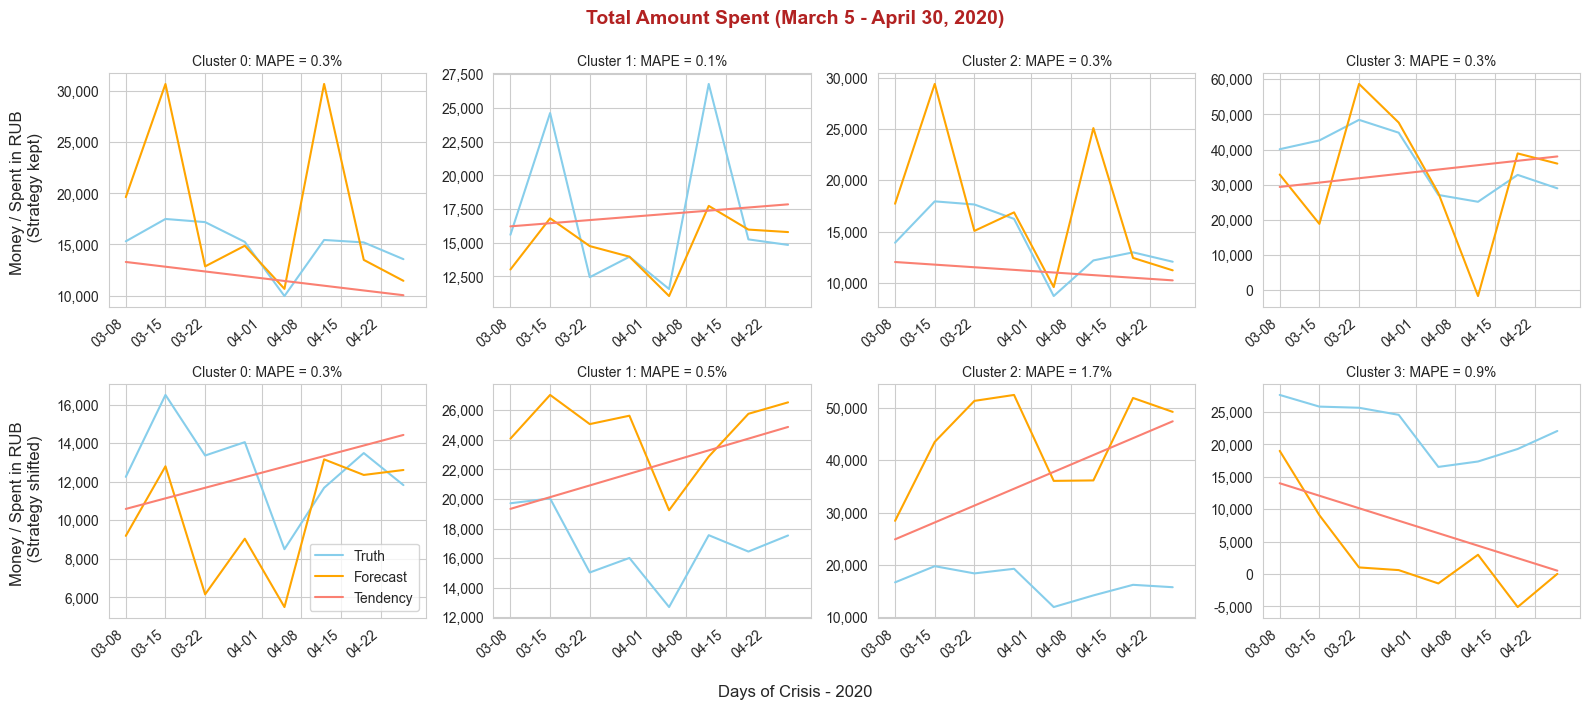

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 7))
ax = ax.flat

for i in range(0, 8, 1):
    if i == 0:
        multivariate_df = working_df_clusters_2020_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'y', 'Cluster_1', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, [0,2,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, [0,2,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency')  

        ax[i].set_title(f'Cluster 0: MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB \n (Strategy kept)', labelpad=10, fontsize=12)
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
        
    elif i == 1:
        multivariate_df = working_df_clusters_2020_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'y', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, [0,1,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, 2])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, [0,1,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, 2])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 1: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 2:
        multivariate_df = working_df_clusters_2020_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'y', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, [0,1,2,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, 3])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, [0,1,2,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, 3])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 2: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    elif i == 3:
        multivariate_df = working_df_clusters_2020_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, [0,1,2,3]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_kept, 4])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, [0,1,2,3]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_kept:, 4])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 3: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 4:
        multivariate_df = working_df_clusters_2020_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'y', 'Cluster_1', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, [0,2,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, [0,2,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency')  

        ax[i].set_title(f'Cluster 0: MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=8)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB \n (Strategy shifted)', labelpad=10, fontsize=12)
        ax[i].set_xlabel('')
        
    elif i == 5:
        multivariate_df = working_df_clusters_2020_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'y', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, [0,1,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, 2])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, [0,1,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, 2])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 1: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 6:
        multivariate_df = working_df_clusters_2020_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'y', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, [0,1,2,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, 3])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, [0,1,2,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, 3])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 2: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    else:
        multivariate_df = working_df_clusters_2020_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, [0,1,2,3]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2020_shifted, 4])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, [0,1,2,3]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2020_shifted:, 4])

        X_train_y_train = multivariate_df.iloc[:train_size_2020_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 3: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
            

fig.suptitle('Total Amount Spent (March 5 - April 30, 2020)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Days of Crisis - 2020', fontsize = 12)
plt.savefig('Cluster_Predictions_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()


---

By summing all clusters together  based on 2019-2020
---

In [ ]:
''' writing the dml '''
sql_query_kept = ''' select 
                            t.Date
                          , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Kept
                    from t_fund_transactions_weekly_sum_by_clusters_2020_kept t 
                    order by t.date 
 '''
sql_query_shifted = ''' select 
                               t.Date
                             , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Shifted
                        from t_fund_transactions_weekly_sum_by_clusters_2020_shifted t
                        order by t.date 
 '''

working_df_clusters_2020_kept_all = spark.sql(sql_query_kept)
working_df_clusters_2020_shifted_all = spark.sql(sql_query_shifted)

working_df_clusters_2020_kept_all.show(5)
working_df_clusters_2020_shifted_all.show(5)

+----------+-----------------+
|      Date|All_Clusters_Kept|
+----------+-----------------+
|2020-02-02|     35935.057897|
|2020-02-09|     66379.921916|
|2020-02-16|     91681.619435|
|2020-02-23|     81875.604602|
|2020-03-01|     72232.019418|
+----------+-----------------+
only showing top 5 rows

+----------+--------------------+
|      Date|All_Clusters_Shifted|
+----------+--------------------+
|2020-02-02|        25674.728710|
|2020-02-09|        66546.890172|
|2020-02-16|        84305.875683|
|2020-02-23|        85626.811916|
|2020-03-01|        70372.704910|
+----------+--------------------+
only showing top 5 rows



In [ ]:
working_df_kept_all = working_df_clusters_2020_kept_all.toPandas()
working_df_kept_all.Date = pd.to_datetime(working_df_kept_all.Date)

working_df_shifted_all = working_df_clusters_2020_shifted_all.toPandas()
working_df_shifted_all.Date = pd.to_datetime(working_df_shifted_all.Date)

train_size_kept = int(0.45 * len(working_df_kept_all))    
train_size_shifted = int(0.45 * len(working_df_shifted_all))  

06:01:12 - cmdstanpy - INFO - Chain [1] start processing
06:01:12 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
06:01:12 - cmdstanpy - INFO - Chain [1] start processing
06:01:12 - cmdstanpy - INFO - Chain [1] done processing


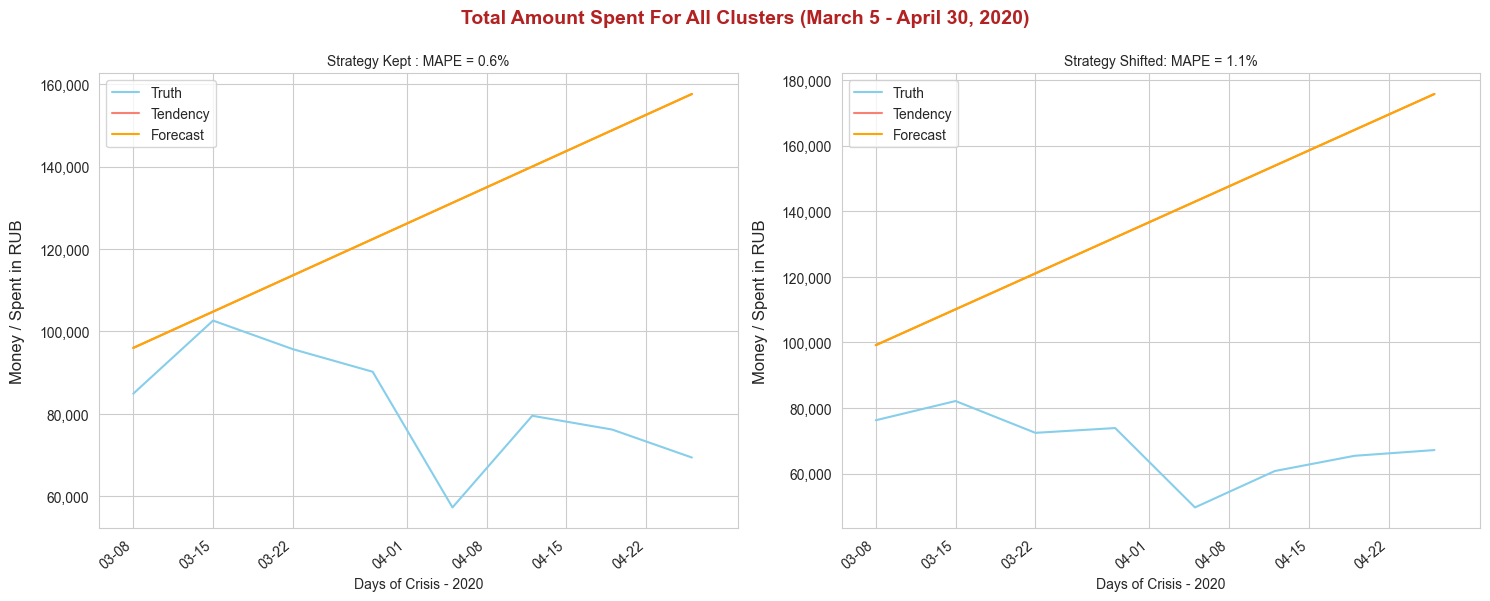

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
ax = ax.flat

for i in range(0, 2, 1):
    
    if i == 0:
        multivariate_df = working_df_kept_all[['Date', 'All_Clusters_Kept']].copy()
        multivariate_df.columns = ['ds', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_kept, [0]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_kept, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_kept:, [0]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_kept:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_kept,:]

        ''' training the model '''
        model = Prophet()

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency')
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')             

        ax[i].set_title(f'Strategy Kept : MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB', labelpad=10, fontsize=12)
        ax[i].set_xlabel('Days of Crisis - 2020')
        
   
    else:
        multivariate_df = working_df_shifted_all[['Date', 'All_Clusters_Shifted']].copy()
        multivariate_df.columns = ['ds', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_shifted, [0]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_shifted, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_shifted:, [0]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_shifted:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_shifted,:]

        ''' training the model '''
        model = Prophet()

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')               

        ax[i].set_title(f'Strategy Shifted: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2020-03-05', format = '%Y-%m-%d'), pd.to_datetime('2020-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB', labelpad=10, fontsize=12)
        ax[i].set_xlabel('Days of Crisis - 2020')
            
            
fig.suptitle('Total Amount Spent For All Clusters (March 5 - April 30, 2020)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Cluster_Predictions_2020_All_Clusters.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

Clients who kept and shifted thier strategy between 2019-2020 and 2021-2022 
---
(i.e. clients who have common clusters in (2019-2020 & 2021-2022) and uncommon clusters in (2019-2020 & 2021-2022))

implementation based on 2021-2022

In [ ]:
temp_kept_client = kept_client
temp_kept_client = temp_kept_client.reset_index()
temp_kept_client = spark.createDataFrame(temp_kept_client, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2021_2022', 'Clusters_2019_2020'])

temp_shifted_client = shifted_client
temp_shifted_client = temp_shifted_client.reset_index()
temp_shifted_client = spark.createDataFrame(temp_shifted_client, schema=['Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2021_2022', 'Clusters_2019_2020'])


df1 = working_df_2022.alias('df1')
df2 = temp_kept_client.alias('df2')
df3 = temp_shifted_client.alias('df3')

temp_df = df1.join(df2, on = col('df1.Client') == col('df2.Client'), how = 'inner')                    
joined_df_2022_kept = temp_df.select([col('df1.Date'), col('df1.Survival'), col('df1.Socialization'), col('df1.Self-Realization'), col('df1.Money')] + [col('df2.Clusters_2021_2022')])

temp_df = df1.join(df3, on = col('df1.Client') == col('df3.Client'), how = 'inner')                    
joined_df_2022_shifted = temp_df.select([col('df1.Date'), col('df1.Survival'), col('df1.Socialization'), col('df1.Self-Realization'), col('df1.Money')] + [col('df3.Clusters_2021_2022')])


''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
joined_df_2022_kept.createOrReplaceTempView('joined_df_2022_kept')
joined_df_2022_shifted.createOrReplaceTempView('joined_df_2022_shifted')

#mode = "overwrite"
#joined_df_2022_kept.write.jdbc(url=url, table='T_SUM_CLUSTERS_2022_kept', mode=mode)
#joined_df_2022_shifted.write.jdbc(url=url, table='T_SUM_CLUSTERS_2022_shifted', mode=mode)


joined_df_2022_kept.show(5)
joined_df_2022_shifted.show(5)

+----------+---------+-------------+----------------+-----------+------------------+
|      Date| Survival|Socialization|Self-Realization|      Money|Clusters_2021_2022|
+----------+---------+-------------+----------------+-----------+------------------+
|2022-04-11|3151.6300|       0.0000|          0.0000|  7500.0000|                 2|
|2022-03-07|2060.4100|    1696.1000|          0.0000|100000.0000|                 2|
|2022-05-23|1354.4700|       0.0000|          0.0000|     0.0000|                 2|
|2022-02-28|7425.3800|       0.0000|          0.0000|     0.0000|                 2|
|2022-03-07|1424.2700|       0.0000|        920.0000|     0.0000|                 2|
+----------+---------+-------------+----------------+-----------+------------------+
only showing top 5 rows

+----------+----------+-------------+----------------+-----------+------------------+
|      Date|  Survival|Socialization|Self-Realization|      Money|Clusters_2021_2022|
+----------+----------+-------------+-

In [ ]:
''' getting the wanted table from ms sql server database  '''
pdf_clusters_2022_kept = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_clusters_2022_kept').load()
pdf_clusters_2022_shifted = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_clusters_2022_shifted').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
pdf_clusters_2022_kept.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_clusters_2022_kept")
pdf_clusters_2022_shifted.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_clusters_2022_shifted")

''' writing the dml '''
sql_query_2022_kept    = ''' select * from t_fund_transactions_weekly_sum_by_clusters_2022_kept t order by t.date  '''
sql_query_2022_shifted = ''' select * from t_fund_transactions_weekly_sum_by_clusters_2022_shifted t order by t.date  '''

pdf_clusters_2022_kept = spark.sql(sql_query_2022_kept)
pdf_clusters_2022_shifted = spark.sql(sql_query_2022_shifted)

working_df_clusters_2022_kept = pdf_clusters_2022_kept
working_df_clusters_2022_shifted = pdf_clusters_2022_shifted

working_df_clusters_2022_kept.show(5)
working_df_clusters_2022_shifted.show(5)

+----------+------------+------------+------------+------------+
|      Date|   Cluster_0|   Cluster_1|   Cluster_2|   Cluster_3|
+----------+------------+------------+------------+------------+
|2022-02-07|14508.038768|11597.713037|11343.486489|19089.502571|
|2022-02-14|17232.602372|17038.779323|14192.139358|24398.878750|
|2022-02-21|14463.617948|13675.383849|14939.219721|28386.579583|
|2022-02-28|22223.688312|17979.704448|20975.185389|32301.367733|
|2022-03-07|18482.891213|28773.971404|20743.611660|45934.948051|
+----------+------------+------------+------------+------------+
only showing top 5 rows

+----------+------------+------------+------------+------------+
|      Date|   Cluster_0|   Cluster_1|   Cluster_2|   Cluster_3|
+----------+------------+------------+------------+------------+
|2022-02-07|15340.628731|11459.722959|11223.528835|23307.793515|
|2022-02-14|18438.109487|14964.880975|14965.822520|19294.824368|
|2022-02-21|20846.453368|15208.834874|15656.739163|20532.900483|


In [ ]:
working_df_clusters_2022_kept = working_df_clusters_2022_kept.toPandas()
working_df_clusters_2022_kept.Date = pd.to_datetime(working_df_clusters_2022_kept.Date)

working_df_clusters_2022_shifted = working_df_clusters_2022_shifted.toPandas()
working_df_clusters_2022_shifted.Date = pd.to_datetime(working_df_clusters_2022_shifted.Date)

train_size_2022_kept = int(0.45 * len(working_df_clusters_2022_kept))   
train_size_2022_shifted = int(0.45 * len(working_df_clusters_2022_shifted))   

06:01:45 - cmdstanpy - INFO - Chain [1] start processing
06:01:52 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
06:01:52 - cmdstanpy - INFO - Chain [1] start processing
06:01:53 - cmdstanpy - INFO - Chain [1] done processing
06:01:53 - cmdstanpy - INFO - Chain [1] start processing
06:01:58 - cmdstanpy - INFO - Chain [1] done processing
06:01:58 - cmdstanpy - INFO - Chain [1] start processing
06:02:03 - cmdstanpy - INFO - Chain [1] done processing
06:02:03 - cmdstanpy - INFO - Chain [1] start processing
06:02:07 - cmdstanpy - INFO - Chain [1] done processing
06:02:08 - cmdstanpy - INFO - Chain [1] start processing
06:02:11 - cmdstanpy - INFO - Chain [1] done processing
06:02:12 - cmdstanpy - INFO - Chain [1] start processing
06:02:13 - cmdstanpy - INFO - Chain [1] done processing
06:02:14 - cmdstanpy - INFO - Chain [1] start proces

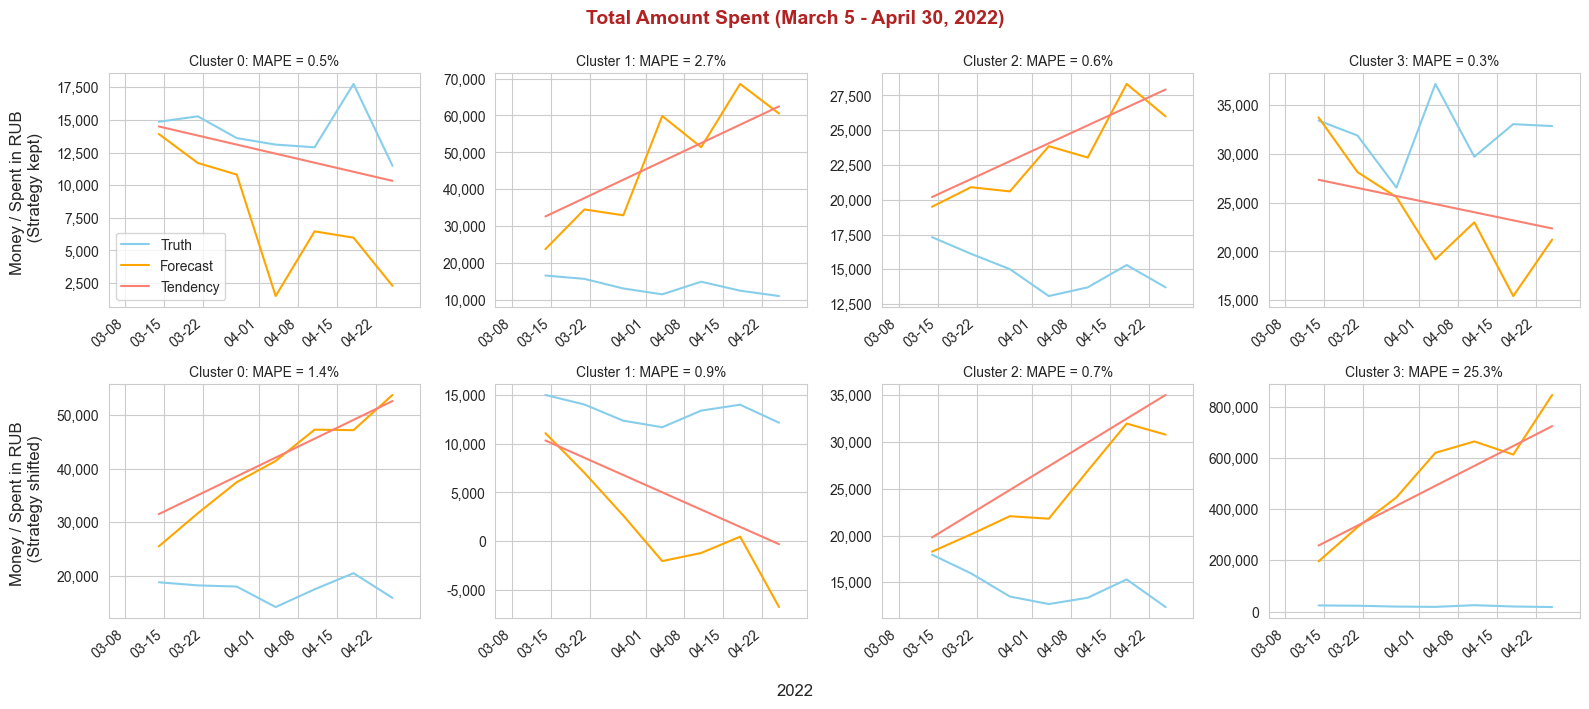

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 7))
ax = ax.flat

for i in range(0, 8, 1):
    if i == 0:
        multivariate_df = working_df_clusters_2022_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'y', 'Cluster_1', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, [0,2,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, [0,2,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency')  

        ax[i].set_title(f'Cluster 0: MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=8)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB \n (Strategy kept)', labelpad=10, fontsize=12)
        ax[i].set_xlabel('')
        
    elif i == 1:
        multivariate_df = working_df_clusters_2022_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'y', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, [0,1,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, 2])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, [0,1,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, 2])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 1: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 2:
        multivariate_df = working_df_clusters_2022_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'y', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, [0,1,2,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, 3])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, [0,1,2,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, 3])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 2: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    elif i == 3:
        multivariate_df = working_df_clusters_2022_kept[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, [0,1,2,3]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_kept, 4])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, [0,1,2,3]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_kept:, 4])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_kept,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 3: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 4:
        multivariate_df = working_df_clusters_2022_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'y', 'Cluster_1', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, [0,2,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, [0,2,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency')  

        ax[i].set_title(f'Cluster 0: MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB \n (Strategy shifted)', labelpad=10, fontsize=12)
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
        
    elif i == 5:
        multivariate_df = working_df_clusters_2022_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'y', 'Cluster_2', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, [0,1,3,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, 2])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, [0,1,3,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, 2])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_2')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 1: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 6:
        multivariate_df = working_df_clusters_2022_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'y', 'Cluster_3']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, [0,1,2,4]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, 3])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, [0,1,2,4]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, 3])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_3')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 2: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    else:
        multivariate_df = working_df_clusters_2022_shifted[['Date', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']].copy()
        multivariate_df.columns = ['ds', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, [0,1,2,3]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_2022_shifted, 4])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, [0,1,2,3]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_2022_shifted:, 4])

        X_train_y_train = multivariate_df.iloc[:train_size_2022_shifted,:]

        ''' training the model '''
        model = Prophet()
        model.add_regressor('Cluster_0')
        model.add_regressor('Cluster_1')
        model.add_regressor('Cluster_2')

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')        
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 

        ax[i].set_title(f'Cluster 3: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
            


fig.suptitle('Total Amount Spent (March 5 - April 30, 2022)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('2022', fontsize = 12)
plt.savefig('Cluster_Predictions_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

By summing all clusters together  based on 2021-2022
---

In [ ]:
''' writing the dml '''
sql_query_kept = ''' select 
                            t.Date
                          , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Kept
                    from t_fund_transactions_weekly_sum_by_clusters_2022_kept t 
                    order by t.date 
 '''
sql_query_shifted = ''' select 
                               t.Date
                             , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Shifted
                        from t_fund_transactions_weekly_sum_by_clusters_2022_shifted t
                        order by t.date 
 '''

working_df_clusters_2022_kept_all = spark.sql(sql_query_kept)
working_df_clusters_2022_shifted_all = spark.sql(sql_query_shifted)

working_df_clusters_2022_kept_all.show(5)
working_df_clusters_2022_shifted_all.show(5)

+----------+-----------------+
|      Date|All_Clusters_Kept|
+----------+-----------------+
|2022-02-07|     56538.740865|
|2022-02-14|     72862.399803|
|2022-02-21|     71464.801101|
|2022-02-28|     93479.945882|
|2022-03-07|    113935.422328|
+----------+-----------------+
only showing top 5 rows

+----------+--------------------+
|      Date|All_Clusters_Shifted|
+----------+--------------------+
|2022-02-07|        61331.674040|
|2022-02-14|        67663.637350|
|2022-02-21|        72244.927888|
|2022-02-28|        91273.128095|
|2022-03-07|        95405.740928|
+----------+--------------------+
only showing top 5 rows



In [ ]:
working_df_kept_all = working_df_clusters_2022_kept_all.toPandas()
working_df_kept_all.Date = pd.to_datetime(working_df_kept_all.Date)

working_df_shifted_all = working_df_clusters_2022_shifted_all.toPandas()
working_df_shifted_all.Date = pd.to_datetime(working_df_shifted_all.Date)

train_size_kept = int(0.45 * len(working_df_kept_all))    
train_size_shifted = int(0.45 * len(working_df_shifted_all))    

06:02:27 - cmdstanpy - INFO - Chain [1] start processing
06:02:28 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
06:02:28 - cmdstanpy - INFO - Chain [1] start processing
06:02:28 - cmdstanpy - INFO - Chain [1] done processing


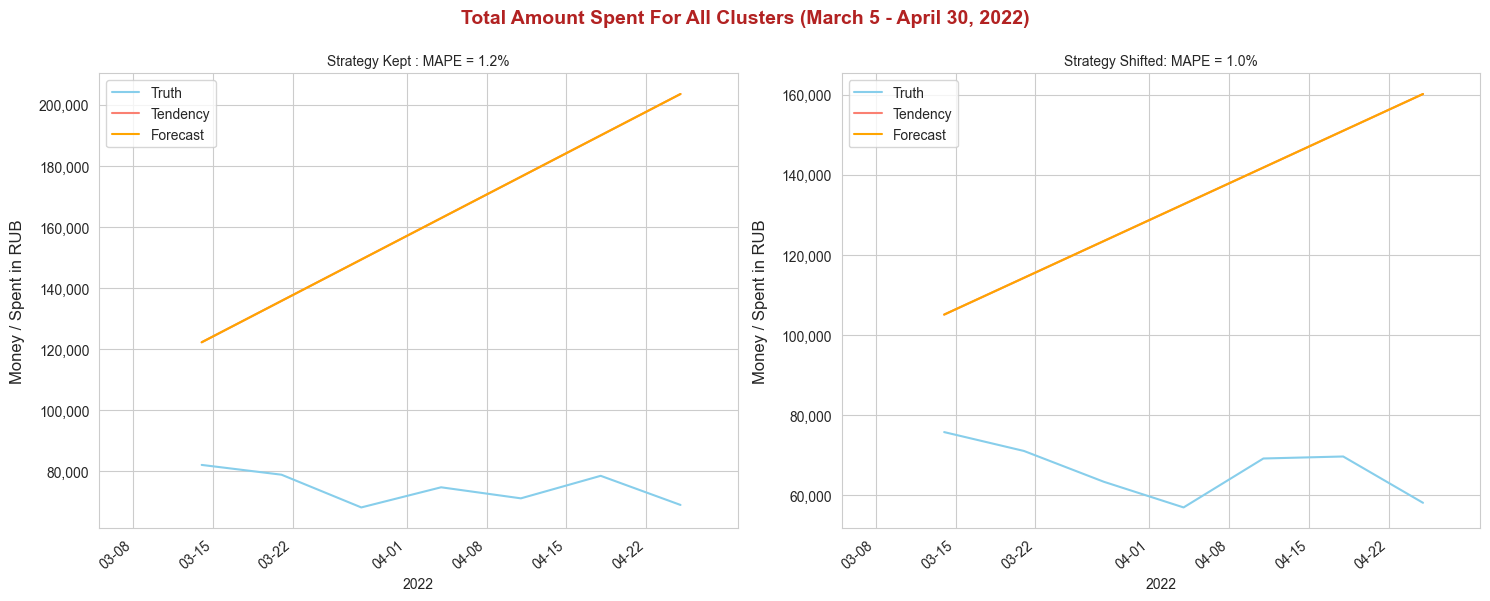

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
ax = ax.flat

for i in range(0, 2, 1):
    
    if i == 0:
        multivariate_df = working_df_kept_all[['Date', 'All_Clusters_Kept']].copy()
        multivariate_df.columns = ['ds', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_kept, [0]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_kept, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_kept:, [0]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_kept:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_kept,:]

        ''' training the model '''
        model = Prophet()

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency')
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')             

        ax[i].set_title(f'Strategy Kept : MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB', labelpad=10, fontsize=12)
        ax[i].set_xlabel('2022')
        
   
    else:
        multivariate_df = working_df_shifted_all[['Date', 'All_Clusters_Shifted']].copy()
        multivariate_df.columns = ['ds', 'y']

        X_train = pd.DataFrame(multivariate_df.iloc[:train_size_shifted, [0]])
        y_train =  pd.DataFrame(multivariate_df.iloc[:train_size_shifted, 1])

        X_validation = pd.DataFrame(multivariate_df.iloc[train_size_shifted:, [0]])
        y_validation =  pd.DataFrame(multivariate_df.iloc[train_size_shifted:, 1])

        X_train_y_train = multivariate_df.iloc[:train_size_shifted,:]

        ''' training the model '''
        model = Prophet()

        fitted_model = model.fit(X_train_y_train)                               # fitting the model with train set

        predicted_values_validation = fitted_model.predict(X_validation)        # predicting on valid set

        mape = mean_absolute_percentage_error(y_validation, predicted_values_validation['yhat'])

        sns.lineplot(x=X_validation['ds'], y=y_validation['y'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['trend'], ax=ax[i], color='salmon', label='Tendency') 
        sns.lineplot(x=predicted_values_validation['ds'], y=predicted_values_validation['yhat'], ax=ax[i], color='orange', label='Forecast')               

        ax[i].set_title(f'Strategy Shifted: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-03-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB', labelpad=10, fontsize=12)
        ax[i].set_xlabel('2022')
            
            
fig.suptitle('Total Amount Spent For All Clusters (March 5 - April 30, 2022)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Cluster_Predictions_2022_All_Clusters.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

Supplementary study using efficient low level implementations of standard linear algebra algorithm such as the Frobenius norm
---

In [ ]:
working_df_clusters_2020_kept = pdf_clusters_2020_kept
working_df_clusters_2020_shifted = pdf_clusters_2020_shifted

working_df_clusters_2022_kept = pdf_clusters_2022_kept
working_df_clusters_2022_shifted = pdf_clusters_2022_shifted

working_df_clusters_2020_kept.show(5)
working_df_clusters_2020_shifted.show(5)

working_df_clusters_2022_kept.show(5)
working_df_clusters_2022_shifted.show(5)

+----------+------------+------------+------------+------------+
|      Date|   Cluster_0|   Cluster_1|   Cluster_2|   Cluster_3|
+----------+------------+------------+------------+------------+
|2020-02-02| 6066.973391| 6387.963188| 4807.195449|18672.925869|
|2020-02-09|11812.448760|13808.772110|13437.524429|27321.176617|
|2020-02-16|22838.636132|23840.635379|17848.586496|27153.761428|
|2020-02-23|17085.328540|16580.218627|14965.195988|33244.861447|
|2020-03-01|14908.798357|16947.616444|13927.153335|26448.451282|
+----------+------------+------------+------------+------------+
only showing top 5 rows

+----------+------------+------------+------------+------------+
|      Date|   Cluster_0|   Cluster_1|   Cluster_2|   Cluster_3|
+----------+------------+------------+------------+------------+
|2020-02-02| 5105.764675| 7820.168218| 5867.928290| 6880.867527|
|2020-02-09|11303.126318|17247.217391|15905.030546|22091.515917|
|2020-02-16|17810.950204|23532.000242|20017.757110|22945.168127|


In [ ]:
working_df_clusters_2022_kept = working_df_clusters_2022_kept.toPandas()
working_df_clusters_2022_kept.Date = pd.to_datetime(working_df_clusters_2022_kept.Date)

working_df_clusters_2020_kept = working_df_clusters_2020_kept.toPandas()
working_df_clusters_2020_kept.Date = pd.to_datetime(working_df_clusters_2020_kept.Date)

working_df_clusters_2022_shifted = working_df_clusters_2022_shifted.toPandas()
working_df_clusters_2022_shifted.Date = pd.to_datetime(working_df_clusters_2022_shifted.Date)

working_df_clusters_2020_shifted = working_df_clusters_2020_shifted.toPandas()
working_df_clusters_2020_shifted.Date = pd.to_datetime(working_df_clusters_2020_shifted.Date)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


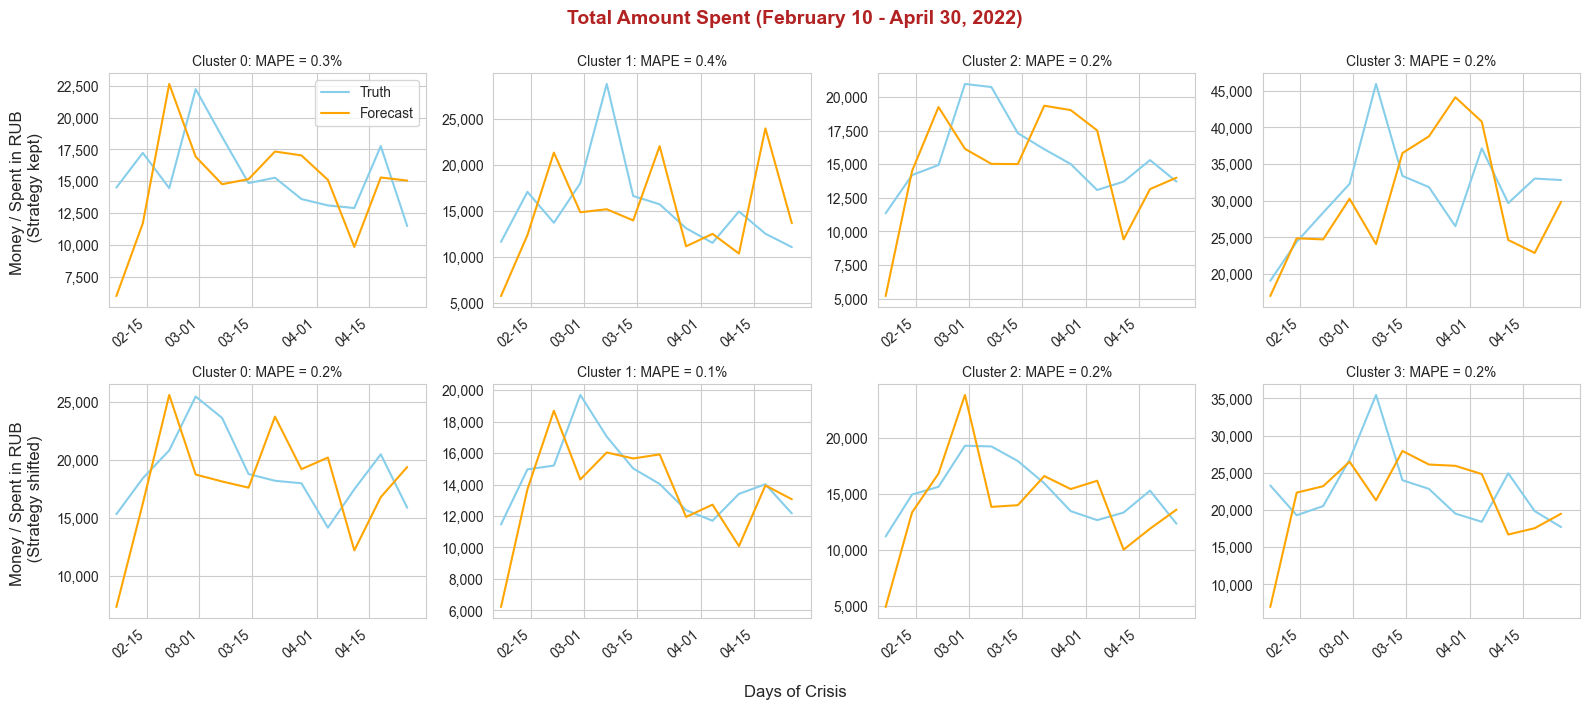

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 7))
ax = ax.flat

for i in range(0, 8, 1):

    if i == 0:

        k = LosAngeles.norm(working_df_clusters_2022_kept['Cluster_0'].values)/LosAngeles.norm(working_df_clusters_2020_kept['Cluster_0'].values)
                                
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = working_df_clusters_2022_kept['Cluster_0'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = k * working_df_clusters_2020_kept['Cluster_0'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,1], working_df_clusters_2020_kept.iloc[:12,1] * k)
  
        ax[i].set_title(f'Cluster 0: MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=8)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB \n (Strategy kept)', labelpad=10, fontsize=12)
        ax[i].set_xlabel('')
        
   
    elif i == 1:


        k = LosAngeles.norm(working_df_clusters_2022_kept['Cluster_1'].values)/LosAngeles.norm(working_df_clusters_2020_kept['Cluster_1'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = working_df_clusters_2022_kept['Cluster_1'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = k * working_df_clusters_2020_kept['Cluster_1'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,2], working_df_clusters_2020_kept.iloc[:12,2] * k)


        ax[i].set_title(f'Cluster 1: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 2:

        k = LosAngeles.norm(working_df_clusters_2022_kept['Cluster_2'].values)/LosAngeles.norm(working_df_clusters_2020_kept['Cluster_2'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = working_df_clusters_2022_kept['Cluster_2'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = k * working_df_clusters_2020_kept['Cluster_2'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,3], working_df_clusters_2020_kept.iloc[:12,3] * k)


        ax[i].set_title(f'Cluster 2: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    elif i == 3:

        k = LosAngeles.norm(working_df_clusters_2022_kept['Cluster_3'].values)/LosAngeles.norm(working_df_clusters_2020_kept['Cluster_3'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = working_df_clusters_2022_kept['Cluster_3'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept['Date'], y = k * working_df_clusters_2020_kept['Cluster_3'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,4], working_df_clusters_2020_kept.iloc[:12,4] * k)


        ax[i].set_title(f'Cluster 3: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()



    elif i == 4:

        k = LosAngeles.norm(working_df_clusters_2022_shifted['Cluster_0'].values)/LosAngeles.norm(working_df_clusters_2020_shifted['Cluster_0'].values)
                                
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = working_df_clusters_2022_shifted['Cluster_0'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = k * working_df_clusters_2020_shifted['Cluster_0'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_clusters_2022_shifted.iloc[:,1], working_df_clusters_2020_shifted.iloc[:12,1] * k)

        ax[i].set_title(f'Cluster 0: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB \n (Strategy shifted)', labelpad=10, fontsize=12)
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()  
   
   
    elif i == 5:

        k = LosAngeles.norm(working_df_clusters_2022_shifted['Cluster_1'].values)/LosAngeles.norm(working_df_clusters_2020_shifted['Cluster_1'].values)
                                
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = working_df_clusters_2022_shifted['Cluster_1'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = k * working_df_clusters_2020_shifted['Cluster_1'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_clusters_2022_shifted.iloc[:,2], working_df_clusters_2020_shifted.iloc[:12,2] * k)

        ax[i].set_title(f'Cluster 1: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()   
   
   
    elif i == 6:

        k = LosAngeles.norm(working_df_clusters_2022_shifted['Cluster_2'].values)/LosAngeles.norm(working_df_clusters_2020_shifted['Cluster_2'].values)
                                
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = working_df_clusters_2022_shifted['Cluster_2'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = k * working_df_clusters_2020_shifted['Cluster_2'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_clusters_2022_shifted.iloc[:,3], working_df_clusters_2020_shifted.iloc[:12,3] * k)

        ax[i].set_title(f'Cluster 2: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()   
   
   
    else:

        k = LosAngeles.norm(working_df_clusters_2022_shifted['Cluster_3'].values)/LosAngeles.norm(working_df_clusters_2020_shifted['Cluster_3'].values)
                                
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = working_df_clusters_2022_shifted['Cluster_3'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_shifted['Date'], y = k * working_df_clusters_2020_shifted['Cluster_3'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_clusters_2022_shifted.iloc[:,4], working_df_clusters_2020_shifted.iloc[:12,4] * k)

        ax[i].set_title(f'Cluster 3: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()  
   

 
            
fig.suptitle('Total Amount Spent (February 10 - April 30, 2022)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Days of Crisis', fontsize = 12)
plt.savefig('Cluster_Predictions_2020_norm.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

---

By summing all clusters together for this approach
---

In [ ]:
''' writing the dml '''
sql_query_kept_2022 = ''' select 
                            t.Date
                          , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Kept_2022
                    from t_fund_transactions_weekly_sum_by_clusters_2022_kept t 
                    order by t.date 
 '''
sql_query_shifted_2022 = ''' select 
                               t.Date
                             , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Shifted_2022
                        from t_fund_transactions_weekly_sum_by_clusters_2022_shifted t
                        order by t.date 
 '''
sql_query_kept_2020 = ''' select 
                            t.Date
                          , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Kept_2020
                    from t_fund_transactions_weekly_sum_by_clusters_2020_kept t
                    order by t.date 
 '''
sql_query_shifted_2020 = ''' select 
                               t.Date
                             , (t.Cluster_0 + t.Cluster_1 + t.Cluster_2 + t.Cluster_3) as All_Clusters_Shifted_2020
                        from t_fund_transactions_weekly_sum_by_clusters_2020_shifted t
                        order by t.date 
 '''

working_df_clusters_2022_kept_all = spark.sql(sql_query_kept_2022)
working_df_clusters_2022_shifted_all = spark.sql(sql_query_shifted_2022)

working_df_clusters_2020_kept_all = spark.sql(sql_query_kept_2020)
working_df_clusters_2020_shifted_all = spark.sql(sql_query_shifted_2020)

In [ ]:
working_df_clusters_2022_kept_all.show(5)
working_df_clusters_2022_shifted_all.show(5)

working_df_clusters_2020_kept_all.show(5)
working_df_clusters_2020_shifted_all.show(5)

+----------+----------------------+
|      Date|All_Clusters_Kept_2022|
+----------+----------------------+
|2022-02-07|          56538.740865|
|2022-02-14|          72862.399803|
|2022-02-21|          71464.801101|
|2022-02-28|          93479.945882|
|2022-03-07|         113935.422328|
+----------+----------------------+
only showing top 5 rows

+----------+-------------------------+
|      Date|All_Clusters_Shifted_2022|
+----------+-------------------------+
|2022-02-07|             61331.674040|
|2022-02-14|             67663.637350|
|2022-02-21|             72244.927888|
|2022-02-28|             91273.128095|
|2022-03-07|             95405.740928|
+----------+-------------------------+
only showing top 5 rows

+----------+----------------------+
|      Date|All_Clusters_Kept_2020|
+----------+----------------------+
|2020-02-02|          35935.057897|
|2020-02-09|          66379.921916|
|2020-02-16|          91681.619435|
|2020-02-23|          81875.604602|
|2020-03-01|          7

In [ ]:
working_df_kept_2022_all = working_df_clusters_2022_kept_all.toPandas()
working_df_kept_2022_all.Date = pd.to_datetime(working_df_kept_2022_all.Date)

working_df_shifted_2022_all = working_df_clusters_2022_shifted_all.toPandas()
working_df_shifted_2022_all.Date = pd.to_datetime(working_df_shifted_2022_all.Date)


working_df_kept_2020_all = working_df_clusters_2020_kept_all.toPandas()
working_df_kept_2020_all.Date = pd.to_datetime(working_df_kept_2020_all.Date)

working_df_shifted_2020_all = working_df_clusters_2020_shifted_all.toPandas()
working_df_shifted_2020_all.Date = pd.to_datetime(working_df_shifted_2020_all.Date)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


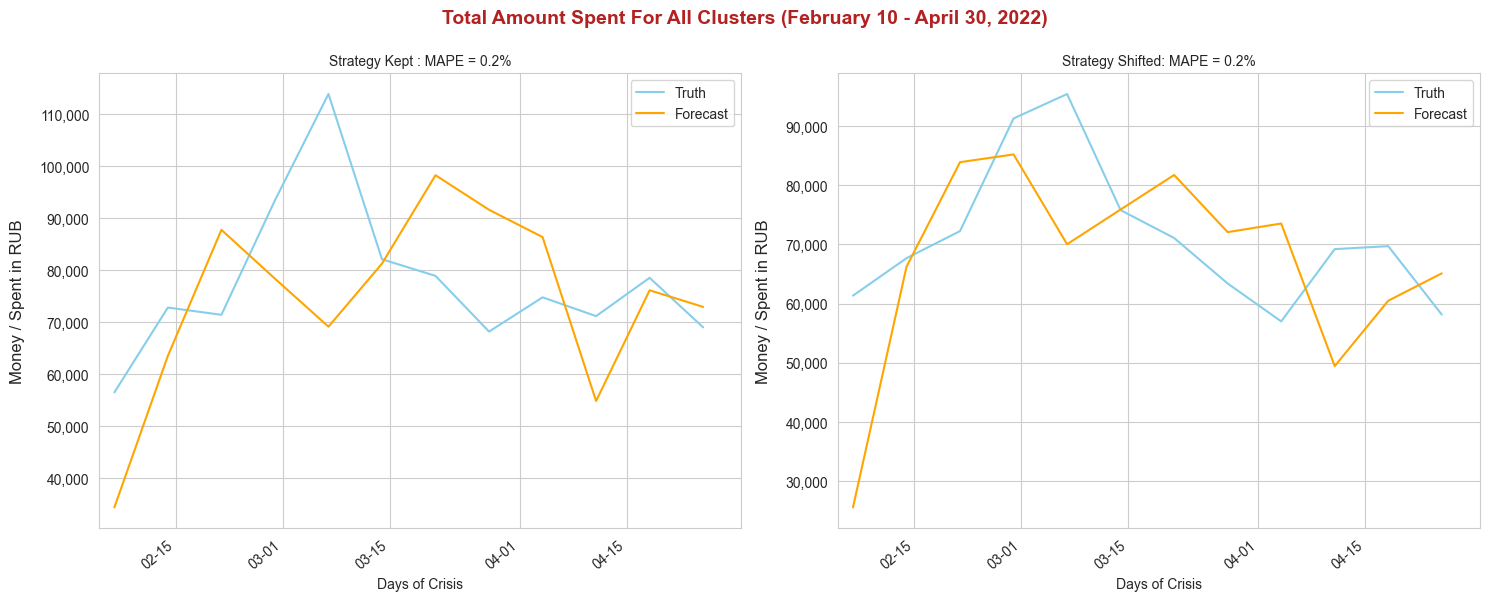

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
ax = ax.flat
 
for i in range(0, 2, 1):
    
    if i == 0:

        k = LosAngeles.norm(working_df_kept_2022_all['All_Clusters_Kept_2022'].values)/LosAngeles.norm(working_df_kept_2020_all['All_Clusters_Kept_2020'].values)
                                
        sns.lineplot(x=working_df_kept_2022_all['Date'], y = working_df_kept_2022_all['All_Clusters_Kept_2022'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_kept_2022_all['Date'], y = k * working_df_kept_2020_all['All_Clusters_Kept_2020'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_kept_2022_all.iloc[:,1], working_df_kept_2020_all.iloc[:12,1] * k)       

        ax[i].set_title(f'Strategy Kept : MAPE = {mape:.1f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB', labelpad=10, fontsize=12)
        ax[i].set_xlabel('Days of Crisis')
        
   
    else:


        k = LosAngeles.norm(working_df_shifted_2022_all['All_Clusters_Shifted_2022'].values)/LosAngeles.norm(working_df_shifted_2020_all['All_Clusters_Shifted_2020'].values)
                                
        sns.lineplot(x=working_df_shifted_2022_all['Date'], y = working_df_shifted_2022_all['All_Clusters_Shifted_2022'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_shifted_2022_all['Date'], y = k * working_df_shifted_2020_all['All_Clusters_Shifted_2020'], ax=ax[i], color='orange', label='Forecast')       

        mape = mean_absolute_percentage_error(working_df_shifted_2022_all.iloc[:,1], working_df_shifted_2020_all.iloc[:12,1] * k)              

        ax[i].set_title(f'Strategy Shifted: MAPE = {mape:.1f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlim([pd.to_datetime('2022-02-05', format = '%Y-%m-%d'), pd.to_datetime('2022-04-30', format = '%Y-%m-%d')])
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40, horizontalalignment='right', fontsize=10)
        plt.legend(loc='best', fontsize=10)
        ax[i].set_ylabel(ylabel='Money / Spent in RUB', labelpad=10, fontsize=12)
        ax[i].set_xlabel('Days of Crisis')
            
            
fig.suptitle('Total Amount Spent For All Clusters (February 10 - April 30, 2022)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
plt.savefig('Cluster_Predictions_all_norm.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()


''' NOTES'''
<!-- 
# Create an empty DataFrame with column names
df = pd.DataFrame(columns=['Column 1', 'Column 2', 'Column 3']) -->


<!-- # in terminal first
python -V   
# then
python -m pip install pmdarim -->


<!-- def create_features(df, label):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='Survival')
X_validation, y_validation = create_features(data_validation, label='Survival') -->


<!-- 
df.iloc[:5,] #First 5 rows
df.iloc[1:5,] #Second to Fifth row
df.iloc[5,0] #Sixth row and 1st column
df.iloc[1:5,0] #Second to Fifth row, first column
df.iloc[1:5,:5] #Second to Fifth row, first 5 columns
df.iloc[2:7,1:3] #Third to Seventh row, 2nd and 3rd column -->



<!-- # acts as a tsql cursor
for row in working_df.itertuples():
  working_df.at[row.Index, 'work_name'] = ' '.join(map(str,spacy_tokenizer(str(working_df.loc[row.Index, 'work_name']))))
  working_df.at[row.Index, 'generalized_work_class'] = ' '.join(map(str,spacy_tokenizer(str(working_df.loc[row.Index, 'generalized_work_class']))))
  working_df.at[row.Index, 'global_work_class'] = ' '.join(map(str,spacy_tokenizer(str(working_df.loc[row.Index, 'global_work_class']))))
  working_df.at[row.Index, 'upper_works'] = ' '.join(map(str,spacy_tokenizer(str(working_df.loc[row.Index, 'upper_works']))))

# counting missing values of each sample/row
for row in working_df.itertuples():
    working_df.at[row.Index, 'missing_count'] = working_df.loc[row.Index, :].isnull().sum() -->



<!-- '''
    Pyspark handles the complexities of multiprocessing, such as :
                            distributing the data, 
                            distributing code and 
                            collecting output from the workers on a cluster/group/set of machines.
    SparkContext:                          
                    SparkContext is the primary point of entry for Spark capabilities. 
                    A SparkContext represents a Spark cluster's connection that is useful in building RDDs, 
                    accumulators, and broadcast variables on the cluster.        
                                    
                    To create a SparkContext you first need to build a SparkConf object that contains 
                    information about your application.                     
                        
    SQLContext:                         
                    SQLContext enables applications to run SQL queries programmatically while running SQL functions and 
                    returns the result as a DataFrame.                         
                           
'''
'''  PySpark SQL Server - via JDBC
     Creating a SparkSession is a basic step to work with PySpark hence, first, let's create a SparkSession 
'''


master = 'local[*]'
conf = SparkConf().setAppName('Master_Thesis_Part_4').setMaster(master).set('spark.driver.extraClassPath','C:\Spark\spark3\jars\sqljdbc_12.6.0.0_enu.jar')
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)
spark = sqlContext.ss

database = 'TransRepository'
table = 'dbo.t_fund_transactions'
user = 'dathscom'
password  = '987654321'

working_df = spark.read.format('jdbc') \
                    .option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver') \
                    .option('url', f'jdbc:sqlserver://DESKTOP-3REJ4PS\\SQLFULL:1433;databaseName={database};encrypt=true;trustServerCertificate=true') \
                    .option('dbtable', table) \
                    .option('user', user) \
                    .option('password', password) \
                    .load()
                   

working_df.show() -->



<!-- working_df = spark.read.jdbc(url, "t_fund_transactions") -->


<!--
temp_df_2020 = working_df_2020.toPandas()
#temp_df_2020.set_index('Client', inplace=True)


temp_table = temp_df_2020
temp_table = temp_table.reset_index()

temp_df_2020 = spark.createDataFrame(temp_df_2020, schema=['Monthly', 'Client', 'Survival', 'Socialization', 'Self-Realization', 'Money', 'Clusters_2020'])

mode = "overwrite"
temp_df_2020.write.jdbc(url=url, table='T_CLUSTERS_2020', mode=mode)

temp_df_2020
-->


<!--

y = temp_df_2022['Cluster_0'].values
x = working_df['Cluster_0'].values

k=np.linalg.norm(temp_df_2022['Cluster_0'].values)/np.linalg.norm(working_df['Cluster_0'].values)

plt.plot(y, label='Real')
plt.plot(x*k, label='Predicted')

-->



<!--

''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_clusters_2022_kept').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_clusters_2022_kept")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_weekly_sum_by_clusters_2022_kept t order by t.date  '''

working_df_clusters_2022_kept = spark.sql(sql_query)


''' getting the wanted table from ms sql server database  '''
working_df = spark.read.format("jdbc").option('driver','com.microsoft.sqlserver.jdbc.SQLServerDriver').option('url',url).option('dbtable','dbo.t_fund_transactions_weekly_sum_by_clusters_2022_shifted').load()

''' if you prefer to write SQL queries, you can register the DataFrame as a temporary table and then use SQL to query the data '''
working_df.createOrReplaceTempView("t_fund_transactions_weekly_sum_by_clusters_2022_shifted")

''' writing the dml '''
sql_query = ''' select * from t_fund_transactions_weekly_sum_by_clusters_2022_shifted t order by t.date  '''

working_df_clusters_2022_shifted = spark.sql(sql_query)




-->